In [4]:
import pandas as pd
import h5py
import os
from PIL import Image
import io
import numpy as np

# 设置路径
csv_file_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\tarin_data\train_labels.csv'
image_folder = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\tarin_data\train'
hdf5_file_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\tarin_data\matched_images.h5'

# 加载CSV文件
labels_df = pd.read_csv(csv_file_path)

# 创建HDF5文件
with h5py.File(hdf5_file_path, 'w') as hf:
    # 标签
    num_images = len(labels_df)
    labels_dset = hf.create_dataset("labels", shape=(num_images,), dtype=np.uint8)
    
    # 图像（保存为原始字节格式）
    images_group = hf.create_group("images")
    
    for idx, row in labels_df.iterrows():
        image_path = os.path.join(image_folder, row['id'] + '.tif')
        
        # 将PIL图像转换为原始字节格式
        with io.BytesIO() as output:
            with Image.open(image_path) as img:
                img.save(output, format="TIFF")
            byte_data = output.getvalue()
        
        # 在HDF5文件中保存原始字节数据
        img_dset_name = str(idx)
        images_group.create_dataset(img_dset_name, data=np.frombuffer(byte_data, dtype=np.uint8))
        
        labels_dset[idx] = row['label']

In [5]:
import h5py

with h5py.File(r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\tarin_data\matched_images.h5', 'r') as file:
    sample_image = file['train_images'][0]  # 加载第一张训练图像作为示例
    print(f"Type of the sample image: {type(sample_image)}")

KeyError: "Unable to open object (object 'train_images' doesn't exist)"

In [9]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split

data_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\tarin_data\matched_images.h5'

def load_images(hf):
    images_group = hf['images']
    return [Image.open(io.BytesIO(np.array(images_group[str(i)]))) for i in range(len(images_group))]

with h5py.File(data_path, 'r') as hf:
    images = load_images(hf)
    labels = hf['labels'][:]

# 使用分层抽样将数据集分为90-10的比例
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.1, random_state=42, stratify=labels
)

output_hdf5_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\tarin_data\split_data.h5'

with h5py.File(output_hdf5_path, 'w') as hf:
    # 创建训练和验证组
    train_group = hf.create_group('train')
    val_group = hf.create_group('val')
    
    # 保存训练图像
    train_images_group = train_group.create_group("images")
    for idx, img in enumerate(train_images):
        with io.BytesIO() as output:
            img.save(output, format="TIFF")
            byte_data = output.getvalue()
        img_dset_name = str(idx)
        train_images_group.create_dataset(img_dset_name, data=np.frombuffer(byte_data, dtype=np.uint8))
    
    # 保存验证图像
    val_images_group = val_group.create_group("images")
    for idx, img in enumerate(val_images):
        with io.BytesIO() as output:
            img.save(output, format="TIFF")
            byte_data = output.getvalue()
        img_dset_name = str(idx)
        val_images_group.create_dataset(img_dset_name, data=np.frombuffer(byte_data, dtype=np.uint8))

    # 保存标签
    hf.create_dataset("train/labels", data=train_labels, dtype=np.uint8)
    hf.create_dataset("val/labels", data=val_labels, dtype=np.uint8)


KeyboardInterrupt: 

In [12]:
import h5py
import numpy as np
from PIL import Image
import io

input_hdf5_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\tarin_data\matched_images.h5'
output_hdf5_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\tarin_data\cropped_data.h5'

def center_crop(img, new_width, new_height):
    width, height = img.size
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    return img.crop((left, top, right, bottom))

with h5py.File(input_hdf5_path, 'r') as input_hf, h5py.File(output_hdf5_path, 'w') as output_hf:
    labels_dset = output_hf.create_dataset("labels", data=input_hf["labels"][:], dtype=np.uint8)
    
    # 创建一个HDF5组来保存裁剪后的PIL图像的原始字节数据
    cropped_images_group = output_hf.create_group("images")
    
    for idx, img_data_name in enumerate(input_hf["images"]):
        img_data = input_hf["images"][img_data_name][:]
    # 使用io.BytesIO从原始字节数据中加载图像
        with io.BytesIO(img_data.tobytes()) as input_stream:
            img = Image.open(input_stream)
        cropped_img = center_crop(img, 32, 32)
    
    # 将PIL图像转换为原始字节数据并保存到HDF5文件
        with io.BytesIO() as output:
            cropped_img.save(output, format="TIFF")
            byte_data = output.getvalue()
    
        img_dset_name = str(idx)
        cropped_images_group.create_dataset(img_dset_name, data=np.frombuffer(byte_data, dtype=np.uint8))

print("Cropping completed and saved to", output_hdf5_path)


ValueError: I/O operation on closed file.

In [1]:
import h5py
import numpy as np
from tqdm import tqdm

def compute_mean_std(h5_file_path):
    with h5py.File(h5_file_path, 'r') as file:
        train_images = file['train_images'][:]

        # 计算均值和标准差
        mean = np.mean(train_images, axis=(0, 1, 2)) / 255.0
        std = np.std(train_images, axis=(0, 1, 2)) / 255.0

    return mean, std

h5_file_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\cropped_data.h5'
mean, std = compute_mean_std(h5_file_path)
print(f"Mean: {mean}, Std: {std}")

False


In [6]:
import h5py
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import io
import numpy as np

# 使用您提供的WSI Normalize均值和标准差
WSI_MEAN = [0.70220305, 0.54459078, 0.69574371]
WSI_STD = [0.23783692, 0.28056477, 0.21528352]

# 数据增强配置
data_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(32, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(WSI_MEAN, WSI_STD)
])

class H5Dataset(Dataset):
    def __init__(self, h5_file, transform=None):
        self.h5_file = h5_file
        self.transform = transform

    def __len__(self):
        return len(self.h5_file["train_images"])

    def __getitem__(self, idx):
        # 从HDF5文件加载PIL图像的原始字节数据，并将其转换为PIL图像
        image_data = self.h5_file["train_images"][str(idx)][:]
        image = Image.open(io.BytesIO(image_data))
        label = self.h5_file["train_labels"][idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# 加载h5文件并对训练数据进行增强
augmented_train_images = []
augmented_train_labels = []
with h5py.File(r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\cropped_data.h5', 'r') as file:
    dataset = H5Dataset(file, transform=data_transforms)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
    for images, labels in train_loader:
        augmented_train_images.append(images.numpy())
        augmented_train_labels.append(labels.numpy())

# 将增强后的数据保存到新的h5文件中
with h5py.File(r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\WSI_data.h5', 'w') as out_file:
    # 保存增强后的训练数据
    out_file.create_dataset("train_images", data=np.concatenate(augmented_train_images, axis=0))
    out_file.create_dataset("train_labels", data=np.concatenate(augmented_train_labels, axis=0))
    
    # 从原始h5文件中复制测试和验证数据
    with h5py.File(r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\cropped_data.h5', 'r') as in_file:
        out_file.create_dataset("test_images", data=in_file["test_images"][:])
        out_file.create_dataset("test_labels", data=in_file["test_labels"][:])
        out_file.create_dataset("val_images", data=in_file["val_images"][:])
        out_file.create_dataset("val_labels", data=in_file["val_labels"][:])



RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [1]:
import torch
print(torch.backends.cudnn.enabled)

True


In [10]:
from PIL import Image
import os
import h5py
import numpy as np

def center_crop_and_save_to_h5(input_dir, output_path):
    images_list = []
    
    # 遍历指定文件夹中的所有图片
    for file_name in os.listdir(input_dir):
        if file_name.endswith('.tif'):  # 只处理 .tif 文件
            file_path = os.path.join(input_dir, file_name)
            image = Image.open(file_path)
            
            # 计算裁剪的起始坐标
            left = (image.width - 32) / 2
            top = (image.height - 32) / 2
            right = (image.width + 32) / 2
            bottom = (image.height + 32) / 2
            
            # 裁剪图片
            cropped_image = image.crop((left, top, right, bottom))
            images_list.append(np.array(cropped_image))
    
    # 将图像列表转换为numpy数组
    images_array = np.array(images_list)
    
    # 保存为.h5文件
    with h5py.File(output_path, 'w') as hf:
        hf.create_dataset("images", data=images_array)

# 指定输入文件夹和输出.h5文件路径
input_directory = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test'
output_h5_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test_data.h5'
center_crop_and_save_to_h5(input_directory, output_h5_path)

In [19]:
import h5py
import numpy as np
from PIL import Image
from torchvision import transforms

# 归一化参数
normalized_mean = 165 / 255
normalized_std = 65 / 255
PIXEL_MEAN = [normalized_mean, normalized_mean, normalized_mean]
PIXEL_STD = [normalized_std, normalized_std, normalized_std]

# 定义归一化的transform
normalize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=PIXEL_MEAN, std=PIXEL_STD)
])

# 输入和输出的文件路径
input_path = 'C:\\Users\\dengz\\Desktop\\DeepLearninig7318\\A2\\histopathologic-cancer-detection\\test_data.h5'
output_path = 'C:\\Users\\dengz\\Desktop\\DeepLearninig7318\\A2\\histopathologic-cancer-detection\\test_data_normal.h5'

# 读取数据
with h5py.File(input_path, 'r') as f_in:
    images = f_in['images'][:]
    image_names = f_in['file_names'][:]
    
    # 对每张图像进行归一化
    normalized_images = []
    for img in images:
        pil_img = Image.fromarray(img)
        normalized_img = normalize_transform(pil_img)
        normalized_images.append(normalized_img.numpy())

    normalized_images = np.array(normalized_images)

    # 保存到新的HDF5文件中
    with h5py.File(output_path, 'w') as f_out:
        f_out.create_dataset('images', data=normalized_images)
        f_out.create_dataset('file_names', data=image_names)


In [3]:
import h5py
import numpy as np
from PIL import Image
from torchvision import transforms
import os

def crop_center(img: Image.Image, crop_width: int, crop_height: int) -> Image.Image:
    """
    裁剪图片到指定大小的中心部分
    """
    width, height = img.size
    left = (width - crop_width) / 2
    top = (height - crop_height) / 2
    right = (width + crop_width) / 2
    bottom = (height + crop_height) / 2
    
    return img.crop((left, top, right, bottom))

# 示例：如果你有一张96x96的图片，这个函数会返回一个32x32的中心部分
# 注意：这里只是一个示例，不会真正执行，因为我们还没有输入图片
# img_sample = Image.open('path_to_your_96x96_image.jpg')
# cropped_img_sample = crop_center(img_sample, 32, 32)
# cropped_img_sample.show()  # 这会显示裁剪后的图片

# 现在，我将继续写代码，将您数据集中的所有图片处理后打包成一个文件。

def process_and_save_to_h5_with_names(input_directory: str, output_h5_path: str):
    """
    处理.tif图片并连同图片名保存为.h5文件
    """
    # 存储所有处理后的图片及其对应的文件名
    all_images = []
    all_names = []
    
    # 遍历输入目录中的所有.tif图片
    for img_name in sorted(os.listdir(input_directory)):
        if img_name.endswith('.tif'):
            img_path = os.path.join(input_directory, img_name)
            
            # 打开并裁剪图片
            img = Image.open(img_path)
            cropped_img = crop_center(img, 32, 32)
            
            # 将PIL图片转换为numpy数组并存储
            img_array = np.array(cropped_img)
            all_images.append(img_array)
            
            # 保存文件名（不带.tif后缀）
            name_without_extension = os.path.splitext(img_name)[0]
            all_names.append(name_without_extension)
    
    all_images_array = np.stack(all_images)
    
    # 保存处理后的图片及其名称到.h5文件
    with h5py.File(output_h5_path, 'w') as hf:
        hf.create_dataset("images", data=all_images_array)
        hf.create_dataset("names", data=all_names, dtype=h5py.string_dtype(encoding='utf-8'))

# 示例使用方式：
input_directory = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test'
output_h5_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test_data_SK.h5'
process_and_save_to_h5_with_names(input_directory,output_h5_path)


In [11]:
# 加载h5文件
with h5py.File(r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test_data_SK.h5', 'r') as file:
    # 列出h5文件中的所有顶级项目
    keys = list(file.keys())

    # 遍历并打印每个项目的名称和形状
    for key in keys:
        data = file[key]
        print(f"Key: {key}, Shape: {data.shape}, Dtype: {data.dtype}")

Key: images, Shape: (57458, 32, 32, 3), Dtype: uint8
Key: names, Shape: (57458,), Dtype: object


In [6]:
import h5py
import numpy as np
from tqdm import tqdm

def compute_mean_std(h5_file_path):
    with h5py.File(h5_file_path, 'r') as file:
        train_images = file['images'][:]

        # 计算均值和标准差
        mean = np.mean(train_images, axis=(0, 1, 2)) / 255.0
        std = np.std(train_images, axis=(0, 1, 2)) / 255.0

    return mean, std

h5_file_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test_data_SK.h5'
mean, std = compute_mean_std(h5_file_path)
print(f"Mean: {mean}, Std: {std}")


Mean: [0.69117415 0.53226126 0.69409107], Std: [0.23868099 0.28092976 0.21214971]


In [9]:
def normalize_and_save_to_h5(input_h5_path: str, output_h5_path: str, mean: list, std: list):
    """
    从.h5文件中读取图片，进行归一化处理，并保存回.h5文件
    """
    with h5py.File(input_h5_path, 'r') as hf:
        images = hf['images'][:]
        names = hf['names'][:]
    
    # 归一化处理
    mean = np.array(mean).reshape(1, 1, 3)
    std = np.array(std).reshape(1, 1, 3)
    normalized_images = (images - mean) / std
    
    # 保存归一化后的图片及其名称到新的.h5文件
    with h5py.File(output_h5_path, 'w') as hf:
        hf.create_dataset("images", data=normalized_images)
        hf.create_dataset("names", data=names, dtype=h5py.string_dtype(encoding='utf-8'))

# 您可以调用此函数并提供相应的路径和给定的均值、标准差来进行归一化处理。
input_directory = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test_data_SK.h5'
output_h5_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test_data_SK_normal.h5'
normalize_and_save_to_h5(input_directory, output_h5_path,[0.69117415, 0.53226126, 0.69409107], [0.23868099, 0.28092976, 0.21214971])

# 注意：这里只是一个示例，不会真正执行，因为我们还没有输入的.h5文件路径。


In [10]:
# 加载h5文件
with h5py.File(r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test_data_SK_normal.h5', 'r') as file:
    # 列出h5文件中的所有顶级项目
    keys = list(file.keys())

    # 遍历并打印每个项目的名称和形状
    for key in keys:
        data = file[key]
        print(f"Key: {key}, Shape: {data.shape}, Dtype: {data.dtype}")

Key: images, Shape: (57458, 32, 32, 3), Dtype: float64
Key: names, Shape: (57458,), Dtype: object


In [2]:
import os
import h5py
from PIL import Image
from torchvision.io import read_image
from torchvision.transforms.functional import center_crop
from torchvision import transforms

WSI_MEAN = [0.70220305, 0.54459078, 0.69574371]
WSI_STD = [0.23783692, 0.28056477, 0.21528352]

val_transforms = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=WSI_MEAN, std=WSI_STD)
])



def process_images(input_folder):
    processed_images = {}
    for image_name in os.listdir(input_folder):
        image_path = os.path.join(input_folder, image_name)
        
        # Using PIL to open and process the image
        with Image.open(image_path) as img:
            # Convert to RGB (in case it's not RGB)
            img = img.convert('RGB')
            # Apply center crop
            cropped_image = center_crop(img, (32, 32))
            # Apply other transformations
            transformed_image = val_transforms(cropped_image)
            # Store in the dictionary
            processed_images[image_name] = transformed_image
    return processed_images



def save_images_to_hdf5(processed_images, output_file):
    # Open the HDF5 file for writing
    with h5py.File(output_file, 'w') as f:
        # For each processed image
        for image_name, image in processed_images.items():
            # Save the image to HDF5
            f.create_dataset(image_name, data=image.numpy())

# Usage
input_folder = r"C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test"  
output_folder = r"C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\new_test.hdf5"  

# Process the images
processed_images = process_images(input_folder)
# Save the processed images to HDF5



NameError: name 'output_file' is not defined

In [3]:
save_images_to_hdf5(processed_images, output_folder)

Number of images: 57458
Overall Min Value: -3.2317557334899902
Overall Max Value: 1.62318754196167
Overall Mean Value: -0.028988365083932877


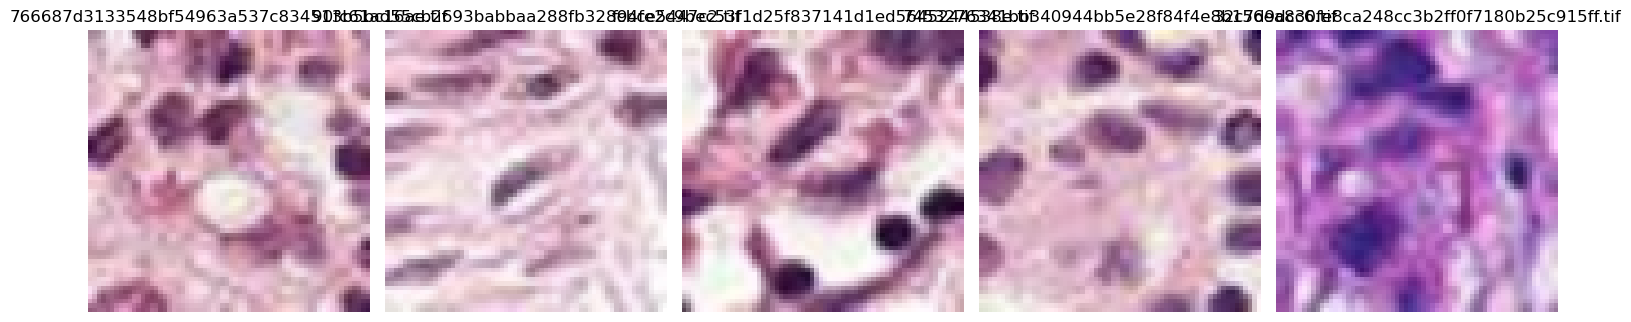

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def visualize_from_hdf5(hdf5_file, num_images=5):
    """
    Load and visualize images from the HDF5 file.
    
    Parameters:
    - hdf5_file: Path to the HDF5 file.
    - num_images: Number of random images to visualize.
    """
    with h5py.File(hdf5_file, 'r') as f:
        # Get random keys (image names)
        keys = list(f.keys())
        selected_keys = np.random.choice(keys, num_images, replace=False)
        
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for ax, key in zip(axes, selected_keys):
            # Get the image and move channels to the end
            image = f[key][...].transpose(1, 2, 0)
            # Denormalize for visualization
            image = image * np.array(WSI_STD) + np.array(WSI_MEAN)
            image = np.clip(image, 0, 1)  # Clip to [0, 1] range
            ax.imshow(image)
            ax.set_title(key)
            ax.axis("off")

        plt.tight_layout()
        plt.show()

def check_processed_data_properties(hdf5_file):
    # Open the HDF5 file
    with h5py.File(hdf5_file, 'r') as f:
        keys = list(f.keys())
        
        all_mins = []
        all_maxs = []
        all_means = []

        for key in keys:
            image = f[key][...]
            
            # Check image dimensions
            assert image.shape == (3, 64, 64), f"Image {key} has incorrect dimensions: {image.shape}"
            
            # Collect statistics
            all_mins.append(image.min())
            all_maxs.append(image.max())
            all_means.append(image.mean())

    print(f"Number of images: {len(keys)}")
    print(f"Overall Min Value: {np.min(all_mins)}")
    print(f"Overall Max Value: {np.max(all_maxs)}")
    print(f"Overall Mean Value: {np.mean(all_means)}")

# Path to your HDF5 file
hdf5_file = r"C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\new_test.hdf5" 

check_processed_data_properties(hdf5_file)

visualize_from_hdf5(hdf5_file)


In [8]:
import h5py

def rename_keys_in_hdf5(hdf5_file):
    with h5py.File(hdf5_file, 'a') as f:
        keys = list(f.keys())
        for key in keys:
            if key.endswith('.tif'):
                new_key = key.replace('.tif', '')
                f[new_key] = f[key]
                del f[key]

hdf5_file = r"C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\new_test.hdf5"
rename_keys_in_hdf5(hdf5_file)


In [9]:
import h5py

def print_image_names(hdf5_file, num_names=5):
    with h5py.File(hdf5_file, 'r') as f:
        keys = list(f.keys())
        for key in keys[:num_names]:
            print(key)

hdf5_file = r"C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\new_test.hdf5" 
print_image_names(hdf5_file)


00006537328c33e284c973d7b39d340809f7271b
0000ec92553fda4ce39889f9226ace43cae3364e
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
000253dfaa0be9d0d100283b22284ab2f6b643f6
000270442cc15af719583a8172c87cd2bd9c7746


In [5]:
from PIL import Image
import os

input_folder = r"C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test"

def check_raw_image_values(input_folder):
    for image_name in os.listdir(input_folder):
        if image_name.endswith('.tif'):
            image_path = os.path.join(input_folder, image_name)
            
            # Load the image using PIL
            image = Image.open(image_path)
            
            # Convert to numpy array for easy processing
            image_np = np.array(image)
            
            print(f"Image: {image_name}")
            print(f"Min Value: {image_np.min()}")
            print(f"Max Value: {image_np.max()}\n")

check_raw_image_values(input_folder)


Image: 00006537328c33e284c973d7b39d340809f7271b.tif
Min Value: 0
Max Value: 255

Image: 0000ec92553fda4ce39889f9226ace43cae3364e.tif
Min Value: 0
Max Value: 255

Image: 00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
Min Value: 0
Max Value: 255

Image: 000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
Min Value: 2
Max Value: 255

Image: 000270442cc15af719583a8172c87cd2bd9c7746.tif
Min Value: 0
Max Value: 255

Image: 000309e669fa3b18fb0ed6a253a2850cce751a95.tif
Min Value: 0
Max Value: 255

Image: 000360e0d8358db520b5c7564ac70c5706a0beb0.tif
Min Value: 0
Max Value: 255

Image: 00040095a4a671280aeb66cb0c9231e6216633b5.tif
Min Value: 0
Max Value: 255

Image: 000698b7df308d75ec9559ef473a588c513a68aa.tif
Min Value: 0
Max Value: 255

Image: 0006e1af5670323331d09880924381d67d79eda0.tif
Min Value: 0
Max Value: 255

Image: 000997a6038fa7441aa0111ac456255060a354c4.tif
Min Value: 0
Max Value: 255

Image: 000c8db3e09f1c0f3652117cf84d78aae100e5a7.tif
Min Value: 0
Max Value: 255

Image: 000de14191f3bab4d2d6a

Image: 023d60a63c8e2306baa8d7439d3786e8918e81ad.tif
Min Value: 9
Max Value: 255

Image: 023df0aeb9c7f08f0ff6ddd621ac5c6ae0186ca2.tif
Min Value: 0
Max Value: 255

Image: 023efab68af49de0538dcd16fa4a262a13712e8c.tif
Min Value: 0
Max Value: 255

Image: 0240d940fe694d84a7d6cb0d56c47f2141c9ac00.tif
Min Value: 0
Max Value: 255

Image: 0241e1a9d5df213b843f873181fc41c51da7cb7a.tif
Min Value: 0
Max Value: 255

Image: 02437b7eec4e70f445793115a751d69a8f0e13f1.tif
Min Value: 0
Max Value: 255

Image: 0243e4a65a2b1d9ce4c66b8d38b7b619fe16afa5.tif
Min Value: 0
Max Value: 255

Image: 0245e07107f05ae3dd59fdc0caf9b758214447b4.tif
Min Value: 0
Max Value: 255

Image: 024626b7ecf484e91c3e06322af49d6574632bfe.tif
Min Value: 0
Max Value: 255

Image: 024919bbde0202bbe40c0e6b5926d84390c53938.tif
Min Value: 97
Max Value: 255

Image: 024a593b9fbc14ef0bc9a4c74245a43868683676.tif
Min Value: 10
Max Value: 255

Image: 024a78a70707975a83d5dcfc1cfe63b538681955.tif
Min Value: 0
Max Value: 255

Image: 024ccbd7cae632ebb83

Image: 048b524e59ad39cba97cfcbcf981ca10284cf3bf.tif
Min Value: 0
Max Value: 255

Image: 048c829268aa7e20182a7f4e3a4ef9ce15c555d4.tif
Min Value: 19
Max Value: 255

Image: 048dc67d1ba90122481625ed0952e7384ba95933.tif
Min Value: 0
Max Value: 255

Image: 048e8741ff457f30357aab9abea2453274121984.tif
Min Value: 0
Max Value: 255

Image: 048e8d7c1313778dd8c6d44dbd7e6c07db5f79d8.tif
Min Value: 0
Max Value: 255

Image: 048ee2f547600b9e3fe8687e697c3d250e849659.tif
Min Value: 0
Max Value: 255

Image: 048fee9b13d2b7049fc8bb17a0ac6d9b14fea233.tif
Min Value: 0
Max Value: 255

Image: 0490866ad2fe34d2dad1e069b8e2309641eb13c2.tif
Min Value: 0
Max Value: 255

Image: 0492cd3723010d0c30acf37cf0abdacc93a5ac82.tif
Min Value: 26
Max Value: 255

Image: 0493ffcfd1526e00970c6ebb1f3cbebb42f982ce.tif
Min Value: 0
Max Value: 255

Image: 049493f41ebb10c931761ebcd3b00d86a8d35f07.tif
Min Value: 0
Max Value: 255

Image: 04950d0f56e24186bbc53e9888820e7a59559544.tif
Min Value: 0
Max Value: 255

Image: 04987424ac505b6965f

Image: 06d2fb8ca317d06df29e276d98a012cb5fe4b672.tif
Min Value: 0
Max Value: 255

Image: 06d48b70c1785dae396ce528af91a9c1416ba57b.tif
Min Value: 0
Max Value: 255

Image: 06d51b458e5441b3ab1104e34e871fbfdfbeb050.tif
Min Value: 0
Max Value: 255

Image: 06d60210d8e2bd89b753dd575c7be8570ee98571.tif
Min Value: 83
Max Value: 255

Image: 06d7b37469d9a169f8f58f1f9989f98bca2d1f66.tif
Min Value: 0
Max Value: 255

Image: 06d80796c9833b490b760b0e039ed0fedc4bb2d5.tif
Min Value: 0
Max Value: 255

Image: 06d89a79d9d14c19ffd565b2ab218531673a8158.tif
Min Value: 0
Max Value: 255

Image: 06de022f1a25f52dfa9dcb01002e787032b22f67.tif
Min Value: 0
Max Value: 255

Image: 06de0b543e18442b0e29038e16dad6b1748e9553.tif
Min Value: 0
Max Value: 255

Image: 06e09c40568b13ebe405cbd003af6325655a0b85.tif
Min Value: 11
Max Value: 255

Image: 06eb64fa9656bbda77bdb10f336a358deef67e54.tif
Min Value: 0
Max Value: 255

Image: 06ec05f7d03565a46b3772b51b29f07dca7693a5.tif
Min Value: 0
Max Value: 255

Image: 06ec9f9c4ff5f3e3b87

Image: 095030bbceef8be79bcf9968468366026d5f74b6.tif
Min Value: 60
Max Value: 255

Image: 0950c07e62f165d02d4789a0e6799718e0238734.tif
Min Value: 0
Max Value: 255

Image: 0952a7784312ef7b63ba213446aaaf16af863683.tif
Min Value: 7
Max Value: 255

Image: 0953676c9c24197f3cc3e6756a7045ac46adad4e.tif
Min Value: 0
Max Value: 255

Image: 09539384d17733363d1d8ed53316647d106b7980.tif
Min Value: 0
Max Value: 255

Image: 0954d5b67f23f2afe1c5c1a1afdcc2b6c413f7d5.tif
Min Value: 0
Max Value: 255

Image: 09559b0666370cb1015504cf1f886086dce0a177.tif
Min Value: 0
Max Value: 255

Image: 0956fdcbff427848f5d759bdeb6e21f6027e9dee.tif
Min Value: 0
Max Value: 255

Image: 0958cc6447e7a60a5ee409d1c2edee0483f9d2d1.tif
Min Value: 0
Max Value: 255

Image: 0959f980fdb2854f2d20ceb2ec95262aff67bfe3.tif
Min Value: 35
Max Value: 255

Image: 095ab2762d9246b8b9f2e9ebbfc55d0ff6eeaae9.tif
Min Value: 9
Max Value: 255

Image: 095bd5e71c304a139e403bcc5234886d70dd7708.tif
Min Value: 0
Max Value: 255

Image: 095be5467fb4ea52d07

Image: 0b39f2569a6fe22ad7df19ca11814f997ce7162c.tif
Min Value: 0
Max Value: 255

Image: 0b3b18666f6bd82dbf733e4af7867f1df9019119.tif
Min Value: 0
Max Value: 255

Image: 0b3c6f9d6227fc3c7393f184f3fa28a6308183c5.tif
Min Value: 0
Max Value: 255

Image: 0b3c82a33c4969147b167d4cbf2ab00af8334e5f.tif
Min Value: 7
Max Value: 255

Image: 0b3ca76b53403d84fb5117642fde43a1e18ef724.tif
Min Value: 29
Max Value: 255

Image: 0b3d80fd7f6819b446143ed705ee0350b6e61faa.tif
Min Value: 0
Max Value: 255

Image: 0b3eb7374ca4eda993fcae6f9cf0a1c0efc2132f.tif
Min Value: 54
Max Value: 255

Image: 0b3ec49f79fa864f9ad9c451d4c793b5d9a99b01.tif
Min Value: 8
Max Value: 255

Image: 0b3f23eb8f363e072696607fdf47f701ff449ca1.tif
Min Value: 0
Max Value: 255

Image: 0b3f760daf9d300c38f348fe57a484a08912e8a3.tif
Min Value: 0
Max Value: 255

Image: 0b3fc7d922d73722d5a432f1c999dc91613ed1bb.tif
Min Value: 0
Max Value: 255

Image: 0b42bf57a0ad1e853c54faf7953b39d033ffadc0.tif
Min Value: 0
Max Value: 255

Image: 0b439c1be8c44e4cdb7

Image: 0dc512dec1d0ca19284e6fc3e3928a92d84c1d44.tif
Min Value: 0
Max Value: 255

Image: 0dc827c3366a25441739895c369d6c257583f45b.tif
Min Value: 12
Max Value: 255

Image: 0dca758ec0e036cc3fb9c88221470a275cefb499.tif
Min Value: 0
Max Value: 255

Image: 0dcbc421583d2da67bd79681d58f6a841a7b9d47.tif
Min Value: 0
Max Value: 255

Image: 0dcbf0591d3e5c86a572dbd8857851ac5f801669.tif
Min Value: 26
Max Value: 255

Image: 0dcd0da40f2e209ae00548653a5ea6b6cacb6f2a.tif
Min Value: 0
Max Value: 255

Image: 0dcd7b7819036d169d987b160d2d7e90337be7f1.tif
Min Value: 0
Max Value: 255

Image: 0dcefe2547e1ccc4b0f8e5bead19157549e8ff4d.tif
Min Value: 0
Max Value: 255

Image: 0dcf68064a4b2ba938be602c6386f79de614f0b7.tif
Min Value: 0
Max Value: 255

Image: 0dd0ea5c00529601fe755a434819f68d2759e9ba.tif
Min Value: 13
Max Value: 255

Image: 0dd1baa652d1450d133e848d74dda7cfc7c25f32.tif
Min Value: 0
Max Value: 255

Image: 0dd59d333b9f8cec0ebfe157a35cfbccb97ed5f4.tif
Min Value: 0
Max Value: 255

Image: 0ddabda6b4b5651a4e

Image: 1014aca4aa0b5eadcfde26ac7d71946d9e21d69f.tif
Min Value: 0
Max Value: 255

Image: 1014c616ffe7937dd082fa67643b74532575de1c.tif
Min Value: 1
Max Value: 255

Image: 10165d204258fa0698985ba8a533d0e01d6fa9fa.tif
Min Value: 3
Max Value: 255

Image: 10167b0d8729afabf567f391a16e7c44466f7555.tif
Min Value: 0
Max Value: 255

Image: 1016d4f70da6b7e506d5d2d060fca1a00e9e1493.tif
Min Value: 0
Max Value: 255

Image: 10174e317e19239f71422282d9ee01f23289ce3d.tif
Min Value: 29
Max Value: 255

Image: 1018777270b3dac4aec930fc948d447ab759fecf.tif
Min Value: 4
Max Value: 255

Image: 10198996a481b5fd5dca7222f6ae909c38c32aa4.tif
Min Value: 0
Max Value: 255

Image: 101a57a1854ba127ae04b785d9880a397d40f08f.tif
Min Value: 24
Max Value: 255

Image: 101efe243ce2c8041aaf2b2208a84b48e3296b02.tif
Min Value: 0
Max Value: 255

Image: 101f2f1564e9e6696aadf39705cf901419e2b5aa.tif
Min Value: 0
Max Value: 255

Image: 10201a05876d0de96f7b0625fb3206e428923b96.tif
Min Value: 0
Max Value: 255

Image: 1022b0fb0fdcbb2b9a6

Image: 128a121618c60ac97906281299dec39dbf8b1c28.tif
Min Value: 8
Max Value: 255

Image: 128dd0200f8f06cb19de0386ba76ee9bd5ab3278.tif
Min Value: 0
Max Value: 255

Image: 128ea852e1b1966da438ef4195fa5ca96a296172.tif
Min Value: 12
Max Value: 255

Image: 1290db5b21c0a72710c8b60fbcad098ec2c74b1c.tif
Min Value: 0
Max Value: 255

Image: 12918965b4d39d95552b6d26beb3b33c2f1f4784.tif
Min Value: 0
Max Value: 255

Image: 12931a18f77af7a9512da7ba89002cb0dd531f65.tif
Min Value: 0
Max Value: 255

Image: 129460a276683d0b9f34d9fcd80b0b37109e276f.tif
Min Value: 20
Max Value: 255

Image: 12949030a0c74d3926aa174439ac88122f53b220.tif
Min Value: 8
Max Value: 255

Image: 12969822e35a98585a1737a3d92062213ad0de7c.tif
Min Value: 0
Max Value: 255

Image: 1297fb846a986b82a29b804214658872ea8dba46.tif
Min Value: 8
Max Value: 255

Image: 12984e136a5e28002e3425d83ab7bd39b359692d.tif
Min Value: 0
Max Value: 255

Image: 129d0e42f32d015a204084364073b357bd70dfa1.tif
Min Value: 9
Max Value: 255

Image: 129f81bfdb9a5e0d848

Image: 14e53897b4510c4675e55148db4901490c0d69c6.tif
Min Value: 0
Max Value: 255

Image: 14e55ab4eb11f90a8e69c1b08d0838144c9a7254.tif
Min Value: 20
Max Value: 255

Image: 14e58f76cd82fdc056981ee1f5df6e401123fdc9.tif
Min Value: 0
Max Value: 255

Image: 14e79b8142277cb4227f829581c9f75e75007d76.tif
Min Value: 0
Max Value: 255

Image: 14e94f4fbd04a5c864607c6a252a7ed51ba997a2.tif
Min Value: 0
Max Value: 255

Image: 14e984a5f214e5035c3eb88913e496c9f97bbbc9.tif
Min Value: 0
Max Value: 255

Image: 14ea33341325608120df957175c69f383b7b1e02.tif
Min Value: 0
Max Value: 255

Image: 14ea8430f013264bfdfc93d7a3303cc168266f73.tif
Min Value: 0
Max Value: 255

Image: 14eaefb2cce3138b15ed044ebd8477e2b2ea80f6.tif
Min Value: 0
Max Value: 255

Image: 14eb27bfac069b094f6b4d818f620710794cb015.tif
Min Value: 0
Max Value: 255

Image: 14eb28d9269bacf3d3cc3ae1716a54f3fe633f71.tif
Min Value: 0
Max Value: 255

Image: 14ebd279f22aadd1b4eb83f0238f8a76c3880356.tif
Min Value: 0
Max Value: 255

Image: 14ed24c2e221a0bba886

Image: 17144ac146660c58ca8506190ae787ad12f42648.tif
Min Value: 0
Max Value: 255

Image: 17153726d8c12307d2a3c0511ccca857e6d28da3.tif
Min Value: 0
Max Value: 255

Image: 1717fcfd7a622eefa9324cc210b250e3357c63e2.tif
Min Value: 0
Max Value: 255

Image: 1719e9690597729f25eceb3d74936506cdf8c144.tif
Min Value: 0
Max Value: 255

Image: 171ba857250f34801e8a34180c2b7cdd38456f55.tif
Min Value: 0
Max Value: 255

Image: 171cdc3b89baaf584f2ab3c3df197612b4498a02.tif
Min Value: 0
Max Value: 255

Image: 171d0ed1730c5f321a0282a6a3ba2abce4edb4f7.tif
Min Value: 0
Max Value: 255

Image: 171de62f0b2a266c7ba8ad1849632a12ad5daa71.tif
Min Value: 0
Max Value: 255

Image: 171e24ca4b1e1633a932ecb823edd14255f9a832.tif
Min Value: 0
Max Value: 255

Image: 171e88392e793147c8ed856099838661733d83a2.tif
Min Value: 0
Max Value: 255

Image: 171f9fa393221e5d769fe9bd9c0dbf325bbc42d6.tif
Min Value: 0
Max Value: 255

Image: 171fddaa56fe7a973ad33a2271827b07b511e768.tif
Min Value: 0
Max Value: 255

Image: 1720abec12343034b322c

Image: 195284193ce9400eec971258a9b8560c8c7919d4.tif
Min Value: 0
Max Value: 255

Image: 19545eaa518c88b6a00e0ec4e7f428ab745c65e3.tif
Min Value: 0
Max Value: 255

Image: 195471ad545ecd6769e0575c2755a78ed476df34.tif
Min Value: 0
Max Value: 255

Image: 195545bbcad52682517173edcb4aef1f64fb6510.tif
Min Value: 0
Max Value: 255

Image: 195550eed829b4040a0ad431af4b956d8d16b22b.tif
Min Value: 0
Max Value: 255

Image: 1958a115b525f268555c59b38da721ab7bb6bbe4.tif
Min Value: 0
Max Value: 255

Image: 19592e8a0527246bd0c2deadd391d3e25bb10c30.tif
Min Value: 33
Max Value: 255

Image: 195932b90657e0697ec5fb8f3609eb3efde7bbd9.tif
Min Value: 0
Max Value: 255

Image: 1959a6379647f1ecf8969540fefb83d70207e85c.tif
Min Value: 0
Max Value: 255

Image: 195a83d2bfe61e7b0e1f2eac9829f330fd5052ec.tif
Min Value: 0
Max Value: 255

Image: 195ab9b104baa50d863c6dfa929ceaa03b3b94b8.tif
Min Value: 0
Max Value: 255

Image: 195d340a124f49fcb44ee1ba5ec1043d4d7062b4.tif
Min Value: 0
Max Value: 255

Image: 195d8141c197f1c7326c

Image: 1bd854fd5d32d8f9797cc60a4d9c121095a5d279.tif
Min Value: 17
Max Value: 255

Image: 1bd8811b23c5beb7255d798d46a5523ae5a6f376.tif
Min Value: 0
Max Value: 255

Image: 1bd951604f8fb0a4d3e340498bb991a77ae8d073.tif
Min Value: 2
Max Value: 255

Image: 1bd9b0fa67b6d4e7316e48d4b18be7395dd50f5a.tif
Min Value: 0
Max Value: 255

Image: 1bd9b7d9732bf1e1bf48df868513580d3a1154c7.tif
Min Value: 0
Max Value: 255

Image: 1bda6a2c3ea32c1dd836fe036cb3333e244fdd76.tif
Min Value: 0
Max Value: 255

Image: 1be0eaf1e3c9e7496a5c3708626ab5b27f4773ab.tif
Min Value: 0
Max Value: 255

Image: 1be1a86c1efa54e4c5ddb5fa147729e3ca5805c3.tif
Min Value: 0
Max Value: 255

Image: 1be1f84867bb7b062eb36011d46be6452dc717fc.tif
Min Value: 0
Max Value: 255

Image: 1be2faa2ce09f274a64328e6d847c670dc85ab13.tif
Min Value: 0
Max Value: 255

Image: 1be50d22d592470c28e022cfb802973fecbe9969.tif
Min Value: 0
Max Value: 255

Image: 1be5271052448119767e2b24b18885feec9116a6.tif
Min Value: 0
Max Value: 255

Image: 1be5967d934e0a6da860

Image: 1e2c30573f58779fb17fdbde984ea4291ab7aa75.tif
Min Value: 0
Max Value: 255

Image: 1e2d8d652bcdb1ce0a2b4b06cfcac1a0312179a1.tif
Min Value: 0
Max Value: 255

Image: 1e2dcb643ae60de942bf68244a93d06b0d1ce11d.tif
Min Value: 0
Max Value: 255

Image: 1e2e633e9f228b1bb67d6fa5c6b91b4253e15ea2.tif
Min Value: 1
Max Value: 255

Image: 1e2f432a2e48402aa0afc411e84bc18445e3cc26.tif
Min Value: 0
Max Value: 255

Image: 1e30850bb423b3fe2cad0d3be758cca8e0e82246.tif
Min Value: 0
Max Value: 255

Image: 1e31744d95aab34b5851b4e489c5ba21151dd6c5.tif
Min Value: 3
Max Value: 255

Image: 1e348e8b0384d404c10f4ff7b76907573499035f.tif
Min Value: 0
Max Value: 255

Image: 1e3490f142a17b0cffe86d785faec7b6a0973322.tif
Min Value: 0
Max Value: 255

Image: 1e353ce02d7197d307b82ef7e50f8925f4d27b53.tif
Min Value: 0
Max Value: 255

Image: 1e35ae689cd0e30a89fbf83b1ea74ea244cd738c.tif
Min Value: 28
Max Value: 255

Image: 1e37df55c0f9e21456f2995ceaff7cbf2bf48787.tif
Min Value: 0
Max Value: 255

Image: 1e39b3b76fe58bceecfd

Image: 20c620da1ceec0d56545df80f6cb095895eeb96d.tif
Min Value: 0
Max Value: 255

Image: 20c687b8ff7586ed3ef574d3b492fc603f4c53ba.tif
Min Value: 2
Max Value: 255

Image: 20c7f48a73c2ffba9072e7f2b815495f8e63e85d.tif
Min Value: 0
Max Value: 255

Image: 20c88c923435e5d668dabed0433eddacc08c41d4.tif
Min Value: 0
Max Value: 255

Image: 20c97f3dc71572cb1db3d83bcf1d50e4e3bc690e.tif
Min Value: 0
Max Value: 255

Image: 20cb7af6a7e7f9cfe51f7b39735e4e4731c91225.tif
Min Value: 0
Max Value: 255

Image: 20ccb7f5213a1921c78b184c84d5904253a2d540.tif
Min Value: 0
Max Value: 255

Image: 20cdb5bd5430a3b854ea0ab352be76240024e39e.tif
Min Value: 101
Max Value: 255

Image: 20d09160baa2f1044fcb823a6292d0f8269ebf11.tif
Min Value: 0
Max Value: 255

Image: 20d2007e583c49f429279b348fe8a65e363b65f9.tif
Min Value: 25
Max Value: 255

Image: 20d27a897862f0d6f40751615dbbc968eeb47e9c.tif
Min Value: 17
Max Value: 255

Image: 20d4df594cc37c0a5d2655f7b9e407d9c89cd47a.tif
Min Value: 0
Max Value: 255

Image: 20d55baa58ed05152

Image: 234dfda4e6370ee6ac175c2fe026c53df2caa7cc.tif
Min Value: 0
Max Value: 255

Image: 234e1522f315d33d66f38940e49e2e27493b698a.tif
Min Value: 0
Max Value: 255

Image: 234ed6f27c74a34ba4a6ef480883ad5927609712.tif
Min Value: 0
Max Value: 255

Image: 234f13b75467a6ce8215c5fb6f1deac2735db16d.tif
Min Value: 0
Max Value: 255

Image: 234ff2cdfa26bfee3b8c4d846275b4087dbcc82b.tif
Min Value: 0
Max Value: 255

Image: 2350cdb274c543a8bb9b74e9ad6f3f8c2a6fe4d6.tif
Min Value: 0
Max Value: 255

Image: 2350d2f5963ed5eef89c147a0bb84bd06c62ba58.tif
Min Value: 0
Max Value: 255

Image: 23526804d8e2567896fb17be1088582e403b696f.tif
Min Value: 0
Max Value: 255

Image: 2356633e653d5868301e14b0c1be5cd2aed97949.tif
Min Value: 0
Max Value: 255

Image: 2356e912866d82b6b375130e073d603da15c020c.tif
Min Value: 38
Max Value: 255

Image: 2357b6a11223485941bb96fd46befd5080faad6c.tif
Min Value: 0
Max Value: 255

Image: 2359346df8c112f5fdf70e59c445c3f1abc4f350.tif
Min Value: 0
Max Value: 255

Image: 2359d69fa1fb93bb2672

Image: 25a8f8b4e1f36c0b1ed7dfdfd50afad17fa41e63.tif
Min Value: 0
Max Value: 255

Image: 25aaf026075a1b6374665b02bf53682d53905b87.tif
Min Value: 1
Max Value: 255

Image: 25ac821e830e8d87734fba794716ccaa326a951f.tif
Min Value: 0
Max Value: 255

Image: 25ad0024c50d4267d6c8afa9f357e8c0701cd988.tif
Min Value: 0
Max Value: 255

Image: 25ad0b0c87c16e55e3162917058480769e868935.tif
Min Value: 21
Max Value: 255

Image: 25afc4450e02ba669679d201561a65c16e5799f1.tif
Min Value: 0
Max Value: 255

Image: 25afdc70163d8217483f55ca8baa0e9087359f29.tif
Min Value: 0
Max Value: 255

Image: 25b332c842c3e361c4fd9417dc5eb79d6cfcf299.tif
Min Value: 0
Max Value: 255

Image: 25b43bbef27dde22bb7696c2d1cd6af925824611.tif
Min Value: 0
Max Value: 255

Image: 25b6f57c553f3b3635660c4bd53bfe09cd8d2030.tif
Min Value: 0
Max Value: 255

Image: 25b7c1eeaf3d2da513d8536016931cb2f695bcf0.tif
Min Value: 1
Max Value: 255

Image: 25b837173e41f6b1c1ea74060666435582303060.tif
Min Value: 0
Max Value: 255

Image: 25baec4373f23180c61b

Image: 280ee499c39db4b25a02c6ab833991dcd0865bb6.tif
Min Value: 0
Max Value: 255

Image: 280eeab8e9764820bb178f8073fc209c01f09949.tif
Min Value: 0
Max Value: 255

Image: 2810ba2772e2bff91cfbad51107046a0fc9f1aa0.tif
Min Value: 0
Max Value: 255

Image: 28120fad6f8b8257b8a131925ce849655cc09486.tif
Min Value: 43
Max Value: 255

Image: 28122ae8ddae1eb6ef7be84061a724a5393f1b14.tif
Min Value: 0
Max Value: 255

Image: 28126ab5e811a90172919444ed41ef2f56b669d6.tif
Min Value: 0
Max Value: 255

Image: 281317521ca94e08b10a4cbcb661723ccd523b89.tif
Min Value: 0
Max Value: 255

Image: 28135360893e184761b168b7becd9a5520272bac.tif
Min Value: 0
Max Value: 255

Image: 2813bfac0e1c49a9bacadd8b9f8b1223ace70f97.tif
Min Value: 0
Max Value: 255

Image: 2813c06058bda6eda543fc050f4e407394b8b314.tif
Min Value: 0
Max Value: 255

Image: 28141fe59e785ec9e0a25a97f5d7f760c8b2b48d.tif
Min Value: 0
Max Value: 255

Image: 2814c256c41069f8b8ebc2f24072ad05e23a3ea9.tif
Min Value: 0
Max Value: 255

Image: 28159e2b081ed58ac4fe

Image: 2a5fcb216c368fbb57ac40a1be2621e6821ab88d.tif
Min Value: 15
Max Value: 255

Image: 2a6038cd0deb7ccfef673c882e068dc2a1642e75.tif
Min Value: 10
Max Value: 255

Image: 2a61083558958b342c359dcb94281deee5dd0f2d.tif
Min Value: 0
Max Value: 255

Image: 2a6119cdd2e45615ca5b6799a7debedd73ea994b.tif
Min Value: 0
Max Value: 255

Image: 2a61f3ff2b01e1abafe199b3f7ffc151b7e07c57.tif
Min Value: 0
Max Value: 255

Image: 2a629b7b629f155b9634bf9e5b4479bd29a34fdb.tif
Min Value: 22
Max Value: 255

Image: 2a6574a9304aaafa331b111b228d43febe390864.tif
Min Value: 0
Max Value: 255

Image: 2a663155f124d40972067177f28b6ecb658a2888.tif
Min Value: 1
Max Value: 255

Image: 2a67cedd599c8e0631d58e99e3639c483c84f8d2.tif
Min Value: 0
Max Value: 255

Image: 2a68527a521c233b7a3883d908576602cce83a5a.tif
Min Value: 20
Max Value: 255

Image: 2a69298eead40e8e03ffdcf52b1e29dd2adcccfa.tif
Min Value: 0
Max Value: 255

Image: 2a696bb33b6b04a6f54030fa63c3373548346957.tif
Min Value: 0
Max Value: 255

Image: 2a6a5800d2669a8c6

Image: 2c7b76a4f7e8d7e20dd0a0e06a6df62b7d4fdbdf.tif
Min Value: 0
Max Value: 255

Image: 2c7bf50b83a78395d31a07fa215cb489771f26f0.tif
Min Value: 7
Max Value: 255

Image: 2c7cd9939beb782a9cbaa30d592867f3e385b93c.tif
Min Value: 0
Max Value: 255

Image: 2c80dd5f893d5ad59dff2e496108bde549682c0f.tif
Min Value: 2
Max Value: 255

Image: 2c80e821dd85699ac32d885201f3d9c50ff5afbd.tif
Min Value: 0
Max Value: 255

Image: 2c8212febdadd732528c9e31aaf18aea8230d40a.tif
Min Value: 0
Max Value: 255

Image: 2c8296b71ad6924d62fae37a3c56c8e1d3d58d84.tif
Min Value: 0
Max Value: 255

Image: 2c835ef1821c385ee71f0087f84df73a61322619.tif
Min Value: 0
Max Value: 255

Image: 2c859b112a23f6563a5b7c869895c386c47248ad.tif
Min Value: 0
Max Value: 255

Image: 2c8711bacf68a84ded28a48f23c6c8e69f78bf61.tif
Min Value: 0
Max Value: 255

Image: 2c8742edf0f72dce76a36fbf917ff85e3ec40c04.tif
Min Value: 0
Max Value: 255

Image: 2c87ab48ed1f8056db1c404d1aec61fc43dea212.tif
Min Value: 0
Max Value: 255

Image: 2c8816d401eed8aed2159

Image: 2ec0a6b198c37e93b64d2fed0c6949b7ac301663.tif
Min Value: 0
Max Value: 255

Image: 2ec4c31f2b2129dbb383292b7436520c4cf2d45b.tif
Min Value: 0
Max Value: 255

Image: 2ec5d3ef2887653075fe1cf15b9857848277c452.tif
Min Value: 0
Max Value: 255

Image: 2ec6f79d8589c6ec2e74fc220e3476e678a20746.tif
Min Value: 0
Max Value: 255

Image: 2ec8a7ff04db0be8c07b40a3cca7b9f88c84a237.tif
Min Value: 0
Max Value: 255

Image: 2ec9e09d6630ef2d61db1d7141c237f9a942fd72.tif
Min Value: 0
Max Value: 255

Image: 2eca0460b53fe52e555a12b88d3945fbd25e8936.tif
Min Value: 0
Max Value: 255

Image: 2ecb0edb2dc85bbffdc7e0955a58ab5c4b0d9314.tif
Min Value: 0
Max Value: 255

Image: 2ecb1b657373874ef97e2bce875c0da62f03990f.tif
Min Value: 0
Max Value: 255

Image: 2ecb3bb5ed7491b636c138e756275454271ec8b8.tif
Min Value: 0
Max Value: 255

Image: 2ecc01745fb64939e0ba780f749e813a93f555e5.tif
Min Value: 0
Max Value: 255

Image: 2ecef994ec5617045af1ac52b961fecfc3766b1d.tif
Min Value: 0
Max Value: 255

Image: 2ecf5e64ffd99c5355703

Image: 31146ef01d988f4caf96e886ce58e1b7990d4ea1.tif
Min Value: 0
Max Value: 255

Image: 3114df29cae584dba41630a5766a01df46b37338.tif
Min Value: 0
Max Value: 255

Image: 31154429c7375a624a0da23ccdd95806ddca3e66.tif
Min Value: 0
Max Value: 255

Image: 31182259f6c3f998fb497e1dc9af82044e05a7a9.tif
Min Value: 0
Max Value: 255

Image: 311b97aa667ad80903fac92469dcb60688dbbbac.tif
Min Value: 0
Max Value: 255

Image: 311c12160d745911887dcde11b2174995d9efc4f.tif
Min Value: 0
Max Value: 255

Image: 311c500fe8077b68e03d3979a0186348b620b5a6.tif
Min Value: 0
Max Value: 255

Image: 311c711c7c236d22ed0e3f66754006c58dd744ce.tif
Min Value: 0
Max Value: 255

Image: 311c7746110547f5b0af44f4a13796e1aa0d5cc3.tif
Min Value: 0
Max Value: 255

Image: 311c7be8d98b14dd77c2bd7c26854e95c65bc0b7.tif
Min Value: 0
Max Value: 255

Image: 311c898121f8689792deedfc7f02df9bc1f1eb70.tif
Min Value: 49
Max Value: 255

Image: 311e59da6164cb1972359b997e42efa7cfb3211c.tif
Min Value: 0
Max Value: 255

Image: 3120a80db9ceeaf39fe2

Image: 334a2b95842b9171274f96be59476f6b2760901d.tif
Min Value: 4
Max Value: 255

Image: 334b8874975d1c8fc913aa39b665d30c4968da8e.tif
Min Value: 0
Max Value: 255

Image: 334da4b18b375ee50dcb97a758d5f2200f6d1e50.tif
Min Value: 0
Max Value: 255

Image: 334f8463165fde70fc57eebb0b52d6c282d71a9e.tif
Min Value: 0
Max Value: 255

Image: 334f870732ef5a0e95f76c20ae4d7707ccd1691c.tif
Min Value: 0
Max Value: 255

Image: 334faf05e788476b30067e91fc51fbe62715b435.tif
Min Value: 0
Max Value: 255

Image: 334fe3bce84ba818e2f01b697735a3124098ccf1.tif
Min Value: 13
Max Value: 255

Image: 334fe500dd69c8858edbfc07f3dd643e0c05bca3.tif
Min Value: 0
Max Value: 255

Image: 3354dfd1befae5252548469723063320415d57cd.tif
Min Value: 0
Max Value: 255

Image: 335573f744ecc6f437040cc1a6e69c9bc506f31f.tif
Min Value: 0
Max Value: 255

Image: 3356c84b1061125f986062c1286ba97974eb4e56.tif
Min Value: 0
Max Value: 255

Image: 33583cc366fd3f0d8fcc5aa3d119e191f3ae4b79.tif
Min Value: 0
Max Value: 255

Image: 3358650a7bca97fd4eaa

Image: 35f1250c3d4343f1e30e8de8fc8421460ee8e9a9.tif
Min Value: 0
Max Value: 255

Image: 35f2023036d42aab1085bbcbb097b9d971456162.tif
Min Value: 14
Max Value: 255

Image: 35f36f264176062d6566abde652a383f853308f7.tif
Min Value: 0
Max Value: 255

Image: 35f564d4217e2a25f278cf7ead5fe4c2d7f21d93.tif
Min Value: 0
Max Value: 255

Image: 35f64117f65d92d3b9dd3f93fad5b256d695678e.tif
Min Value: 18
Max Value: 255

Image: 35f713c6c4b9251fe75c81fab235e76a22090cd2.tif
Min Value: 0
Max Value: 255

Image: 35f75c608eba86085b6f0e2bcec3e4f1c310044a.tif
Min Value: 0
Max Value: 255

Image: 35f76206d915224a3933a41a4443287885fc75bf.tif
Min Value: 17
Max Value: 255

Image: 35f908378ddc65ee56d1d884dd0580bcb491976c.tif
Min Value: 0
Max Value: 255

Image: 35fcb9d838e745a730819387ac32e5ffdc6da8d8.tif
Min Value: 0
Max Value: 255

Image: 35fd5270f3b0c0ec840005b61d196208fec83bdc.tif
Min Value: 0
Max Value: 255

Image: 35ff18a2b5cac78a4f95812ff745f0cc4b97f24f.tif
Min Value: 0
Max Value: 255

Image: 360158e888d03d4228

Image: 38399c34ce2513d2d027791f41e009c73c5914a1.tif
Min Value: 47
Max Value: 255

Image: 3839fdbe57c8d03baaac6983961c0563af48440d.tif
Min Value: 25
Max Value: 255

Image: 383d331c108d1b5447b502bcd72f6d6c52d3bc76.tif
Min Value: 0
Max Value: 255

Image: 383e77a26515f7bf45c03162c7de565615ba2a69.tif
Min Value: 0
Max Value: 255

Image: 383fc80d54387e7b4a3c35b52fa00e9086060d74.tif
Min Value: 0
Max Value: 255

Image: 384037003c1cb5609af477c639866cb0989b58b8.tif
Min Value: 14
Max Value: 255

Image: 384247de8d3ac017e5d433f723cf7ea9ec3da33b.tif
Min Value: 0
Max Value: 255

Image: 38440857edd070b380719015b82892ae9eb69d2e.tif
Min Value: 0
Max Value: 255

Image: 3844fe1160aae82f02623ad0837eb1b0d4d9b685.tif
Min Value: 0
Max Value: 255

Image: 384546593216e282d3cdd61f15ce4576099620f9.tif
Min Value: 0
Max Value: 255

Image: 38454ee2ae8182324b41dcc29b9809a1bb624b2c.tif
Min Value: 0
Max Value: 255

Image: 3845998e80239f96de7a5730eb92147f21b35e9b.tif
Min Value: 0
Max Value: 255

Image: 3845a8f876945f61e7

Image: 3ab032c1fbbf377c3f57d99c258928db38241526.tif
Min Value: 0
Max Value: 255

Image: 3ab1c2f7a04c7d7c3c40d05cd58fb2bcf8bb53e1.tif
Min Value: 6
Max Value: 255

Image: 3ab2583c220598fbef66f6fde951ddab30a48c77.tif
Min Value: 0
Max Value: 255

Image: 3ab2e70da0c1b668410a242e36e2e03089afb505.tif
Min Value: 0
Max Value: 255

Image: 3ab660c3d4d32ba6ba96412ab80e163d7bae3ae4.tif
Min Value: 0
Max Value: 255

Image: 3abb3a576d11f6f88166944f4b979a3ea807db14.tif
Min Value: 0
Max Value: 255

Image: 3abc83f27e5b72b3f7c9f8e5e012bee65e3f2163.tif
Min Value: 0
Max Value: 255

Image: 3abd359881e3f86ae433caa238d798a6525fdab3.tif
Min Value: 0
Max Value: 255

Image: 3abd5542c8f682371b216f04088be63e6f2fca47.tif
Min Value: 0
Max Value: 255

Image: 3abe15ac65fd105d8d911abdfc99272c0b5b46ef.tif
Min Value: 0
Max Value: 255

Image: 3ac12d165c21ebde3c05064916a24f005063a814.tif
Min Value: 0
Max Value: 255

Image: 3ac18221a9d074307f4926bf54026640ed950719.tif
Min Value: 0
Max Value: 255

Image: 3ac26667fcb1cb80f302f

Image: 3d01466351a943e7a729b1289c08f0c0955ed43f.tif
Min Value: 0
Max Value: 255

Image: 3d045008b9d66c59671ab5356c1dd0c22b4abd72.tif
Min Value: 3
Max Value: 255

Image: 3d0481a7eb8b0c387546425192ecdcce4166c4ef.tif
Min Value: 0
Max Value: 255

Image: 3d0594273da8cd43283cfdb4dbb16adbe61f8ee2.tif
Min Value: 0
Max Value: 255

Image: 3d06046c7587bd122c3d5d8987717ff7458f325e.tif
Min Value: 0
Max Value: 255

Image: 3d06df0f341bd3c208a5fe066d51398bba0dc326.tif
Min Value: 0
Max Value: 255

Image: 3d07368a74bd07ce5bbabd3de7a5c249877161ef.tif
Min Value: 0
Max Value: 255

Image: 3d08a68dc1db1ae44f05cb40deef29f6e3f0e39b.tif
Min Value: 0
Max Value: 255

Image: 3d09f8a1c353eae788244a264fa55d76cff6127f.tif
Min Value: 19
Max Value: 255

Image: 3d0b1b77a99d41ddbce1f7333802f2c503f45563.tif
Min Value: 0
Max Value: 255

Image: 3d0b1df7257b08bbe1cda84177c41d97af3be48c.tif
Min Value: 10
Max Value: 255

Image: 3d0b5b2f54ce75a0b8e1bf430948c4359bac3952.tif
Min Value: 0
Max Value: 255

Image: 3d0be7a0439ac7723ba

Image: 3f3eb6ad4c336fc36df0496b3a931bde2ff30c9a.tif
Min Value: 0
Max Value: 255

Image: 3f3eb9a7c95a68c69f20919b232da6913f0d711e.tif
Min Value: 0
Max Value: 255

Image: 3f3f1157c3941bcedd8f9d55c1cf67a649590983.tif
Min Value: 0
Max Value: 255

Image: 3f404ebfe815c636c73d5cb2e621fd31ba3c63ef.tif
Min Value: 0
Max Value: 255

Image: 3f42be548935fd4209919b560998b79419274a46.tif
Min Value: 0
Max Value: 255

Image: 3f448e635cafbeb68a23b1769e7762b673691c82.tif
Min Value: 0
Max Value: 255

Image: 3f44a70d1987d4331e08abe2f4fbb3b746677930.tif
Min Value: 15
Max Value: 255

Image: 3f44e3e97b2433738f3bd2e55459e405ff1a8c12.tif
Min Value: 0
Max Value: 255

Image: 3f4501e716285672691b4298207aaf5d9972273d.tif
Min Value: 0
Max Value: 255

Image: 3f45465a2e21eb045df97d9008ddc9a8ad99cc26.tif
Min Value: 0
Max Value: 255

Image: 3f4585c3c74d6ae6f40784546aee9fb121848895.tif
Min Value: 0
Max Value: 255

Image: 3f469b3d4dbd2690d28e22b808ca1df9a75f84a6.tif
Min Value: 0
Max Value: 255

Image: 3f47833db5c2fa3c22e5

Image: 418bb4ffa73fa29aac6b516bb88ec59494bc7765.tif
Min Value: 16
Max Value: 255

Image: 418c1c669d31e175ee8d78d10f7bf7d54e4d6c99.tif
Min Value: 0
Max Value: 255

Image: 418c780eefe44980d7eafbc1ad2382b3ac1a6552.tif
Min Value: 0
Max Value: 255

Image: 418dacce1adef47c2c030c61912aa5cc9ec246ba.tif
Min Value: 0
Max Value: 255

Image: 418e344a15c303af85d8e05d1bb3977b81298cb1.tif
Min Value: 0
Max Value: 255

Image: 418f53407d7c5f9f73866d6d95f99683c86830c1.tif
Min Value: 0
Max Value: 255

Image: 41901c00c40915b5261740b48f39245e183c0972.tif
Min Value: 28
Max Value: 255

Image: 4191b3081533a7222c8d702e40f11602201a29d4.tif
Min Value: 0
Max Value: 255

Image: 4192392dc10c150c77896b4fa9e254bb6fb34f06.tif
Min Value: 0
Max Value: 255

Image: 4192d061b9c920780daf91a9c798c5034b98e0af.tif
Min Value: 0
Max Value: 255

Image: 4192f3671f238dab2f5524661e88ef3462198f5d.tif
Min Value: 0
Max Value: 255

Image: 41932157f9ef71448a5cc53d63f3e9613382bb6d.tif
Min Value: 0
Max Value: 255

Image: 4196cc4cd3d92dd612d

Image: 4407d221888c2f9723662b39ab44e824c6e9af49.tif
Min Value: 0
Max Value: 255

Image: 44083bd545d8fa93fe20061eafe7218feb0589ee.tif
Min Value: 27
Max Value: 255

Image: 44083ed820fb88a55d36c1998139f4c31af2385d.tif
Min Value: 0
Max Value: 255

Image: 440df572cd6680aeccf36e2d35322034351e46f4.tif
Min Value: 0
Max Value: 255

Image: 440e1eb55d8d3f33de73face286ad2df4d46b406.tif
Min Value: 11
Max Value: 255

Image: 440e53251815be2aff80f98bc76d5c7500e916e8.tif
Min Value: 0
Max Value: 255

Image: 440fa856330c738dabfb13eb50ea62496478ca8d.tif
Min Value: 31
Max Value: 255

Image: 4410275d30419ed8dbd039f41c688f5811d109c7.tif
Min Value: 0
Max Value: 255

Image: 441111755332cb9f9d9253e3c6a92f9080de291f.tif
Min Value: 0
Max Value: 255

Image: 441114a4cd311063f8a86775c903d9705ee95ef2.tif
Min Value: 0
Max Value: 255

Image: 4413c24e461076900ec26202c79635dfddfc11fe.tif
Min Value: 0
Max Value: 255

Image: 4413f74101a41c491f26af5106b6b3ebcdd39fbc.tif
Min Value: 0
Max Value: 255

Image: 4414659ca768a4c2ae

Image: 465ee934efae7da2dc0c3fe12daa864a07a64ed6.tif
Min Value: 0
Max Value: 255

Image: 466151f286d5e6fb02063a9ddc46fe8c3d3c9458.tif
Min Value: 0
Max Value: 255

Image: 46616cb698cff990ad2cd1df40b80e3e97424bb9.tif
Min Value: 32
Max Value: 255

Image: 4661eb18d4c6fb29356c9c604a6b2e9b06103d9c.tif
Min Value: 0
Max Value: 255

Image: 4662a9a0f02bfec3281ceb3ae30ae5d374760f80.tif
Min Value: 0
Max Value: 255

Image: 46641f54350d86cbe411d751072ff7beea2cf6a2.tif
Min Value: 0
Max Value: 255

Image: 4664728262b8832268d8e141d8932cee5b0ed801.tif
Min Value: 10
Max Value: 255

Image: 46654e03850368e9268890dbecc65299874a9868.tif
Min Value: 0
Max Value: 255

Image: 4666023628e2bca0eb9af4743a7b0264a3f2a048.tif
Min Value: 0
Max Value: 255

Image: 466647c8ac9c197546bdf78a394d7a679928e7d4.tif
Min Value: 0
Max Value: 255

Image: 466795b0194556b66ad20985ffff852f3d6e915b.tif
Min Value: 0
Max Value: 255

Image: 46686f043e29591fa58cfbb496c57f600a41732f.tif
Min Value: 1
Max Value: 255

Image: 4668d9232a7e6719e9b

Image: 48bd21b81fcd66bdb8346b5d247397a6f3d390a3.tif
Min Value: 0
Max Value: 255

Image: 48be0865d7528366dc6ff3c05e63936a82383e9f.tif
Min Value: 0
Max Value: 255

Image: 48be17708c01724294db26d48fabd40e15381600.tif
Min Value: 0
Max Value: 255

Image: 48bfad828155e7b2165de82b58a453dd76be1b33.tif
Min Value: 0
Max Value: 255

Image: 48c06e1b88b9b565e754c04a55549fa4ea125c21.tif
Min Value: 24
Max Value: 255

Image: 48c0a9fcd4d36dc3c638d14ce01cfe2f4c2466cf.tif
Min Value: 0
Max Value: 255

Image: 48c14a99cea23b68447c3276d2dd813afcae2fd8.tif
Min Value: 0
Max Value: 255

Image: 48c1e0fcacec50c23d8f69738659a18f4cc19100.tif
Min Value: 47
Max Value: 255

Image: 48c3c14f0e586affbcade27f25cfbb65602ab050.tif
Min Value: 0
Max Value: 255

Image: 48c4d9eb9d2a33d89f98bc819a254dc366882989.tif
Min Value: 0
Max Value: 255

Image: 48c5d7f69ad19e391e9552e234cf2593ee7c961b.tif
Min Value: 0
Max Value: 255

Image: 48c9b97a63df575382a47100654f494721263c7d.tif
Min Value: 0
Max Value: 255

Image: 48ca5235ee5137ab688

Image: 4b370ca87de40be2aa6dda01ab3daa7c59ac48ae.tif
Min Value: 0
Max Value: 255

Image: 4b376d7e21d20c5010f31f3cf757f3dd56a53b11.tif
Min Value: 0
Max Value: 255

Image: 4b39b18da5a24cd93d1e0791d36e2b44977bcc59.tif
Min Value: 2
Max Value: 255

Image: 4b3aeea55b2ce2a770428477fab520fd4ea0d600.tif
Min Value: 0
Max Value: 255

Image: 4b3bd727fbb4b703d5ddd917fd151b48231fdb18.tif
Min Value: 0
Max Value: 255

Image: 4b3c7146d59c03a7f0b7e249ca0b1994d5874478.tif
Min Value: 0
Max Value: 255

Image: 4b3ca0bb08ce98f26972cf12056868efade1aa9e.tif
Min Value: 0
Max Value: 255

Image: 4b3e1aa0e3d429b2a2b37b01460bcec44bee584e.tif
Min Value: 0
Max Value: 255

Image: 4b3e75dc0d079402dcffc0ec297d327f7c77a15d.tif
Min Value: 0
Max Value: 255

Image: 4b3ebf59bb413894a9e5814eb89a2a55e6c372c9.tif
Min Value: 0
Max Value: 255

Image: 4b3ff9ce4a6b5b765e5e225a808d72c362249617.tif
Min Value: 0
Max Value: 255

Image: 4b40a6c074a0c17132b88daeca5a36e1e945f72d.tif
Min Value: 0
Max Value: 255

Image: 4b416d0c3cf11891d812f

Image: 4db75acd9b47b5ca395da26907823345a4799358.tif
Min Value: 0
Max Value: 255

Image: 4db81dcdd19376e713db157168d2a21336d57b12.tif
Min Value: 0
Max Value: 255

Image: 4db991d9378429ef866e2846cf487a12c727ae5f.tif
Min Value: 0
Max Value: 255

Image: 4dbe073e939d37a6ede09944d7cf2010ed45c206.tif
Min Value: 14
Max Value: 255

Image: 4dbed319da7746c758f811b8c7b304764fb9e271.tif
Min Value: 0
Max Value: 255

Image: 4dc14742c77b6ae32cf690d979e8eb28e8121125.tif
Min Value: 0
Max Value: 255

Image: 4dc45caf08fa84f24febb3a7c3fb43b9947f43d3.tif
Min Value: 0
Max Value: 255

Image: 4dc48ac904fc3b9782e1104eacdb561140401454.tif
Min Value: 0
Max Value: 255

Image: 4dc5fb3b05e67195bc659c7aad18992a64c09e5f.tif
Min Value: 0
Max Value: 255

Image: 4dc7c1117aec2dd41b53b32c192318bc77fa1937.tif
Min Value: 0
Max Value: 255

Image: 4dc8b934ce15cde06e5b6fba111bdc073cd1f04f.tif
Min Value: 0
Max Value: 255

Image: 4dc8f9f60cbf3f4f65b5cdc8a1ea80681fdfaecc.tif
Min Value: 0
Max Value: 255

Image: 4dc9246ce1e409739f74

Image: 5014ca53638130c5d4c12a8a713039c455e08224.tif
Min Value: 13
Max Value: 255

Image: 501604bc06498c43146e0abd173b2f598b9b7c82.tif
Min Value: 0
Max Value: 255

Image: 5017d78c304cac99127133507b9260c28a8c5580.tif
Min Value: 0
Max Value: 255

Image: 50183e5f5fba376f0cc9a3a403a51527e0916c26.tif
Min Value: 12
Max Value: 255

Image: 5018c5610bdd60b5569278f1ddcb74440688ce10.tif
Min Value: 0
Max Value: 255

Image: 5019cca29d2a6b72c66e945296de797e87786142.tif
Min Value: 0
Max Value: 255

Image: 501a3be2be077d1ee7872c53d8a7df232303a6ae.tif
Min Value: 0
Max Value: 255

Image: 501adc17f81e2a2383f83bbd99d010050210ee3a.tif
Min Value: 0
Max Value: 255

Image: 501c332cad7e5a94c1296b3b05b9e127dd0483f3.tif
Min Value: 0
Max Value: 255

Image: 501c73812397e3bab3f526a1f625ed9d2965eef3.tif
Min Value: 0
Max Value: 255

Image: 501c921a97a9b958cbc3ed2fb8082a6e3657d75f.tif
Min Value: 0
Max Value: 255

Image: 501e229830af6e8df2cbb5b944c8240ad60df40a.tif
Min Value: 28
Max Value: 255

Image: 501eeeeed48efb723e

Image: 52708c0f7f0e2fe09f39c2d45dac137dfd45b706.tif
Min Value: 0
Max Value: 255

Image: 5271277bfc18680aa89b7d0af66de49eeb7cbb7c.tif
Min Value: 0
Max Value: 255

Image: 5271fa4a502af680cd688abc1b38efdf2976ecce.tif
Min Value: 0
Max Value: 255

Image: 52724116b45b482fd29e4488d8dbd26a11f1ab16.tif
Min Value: 0
Max Value: 255

Image: 527304e4be69f9c890a085e8976ef95decb68a8f.tif
Min Value: 0
Max Value: 255

Image: 52735ba82719e7eb6b456694c6b9d99a52850d40.tif
Min Value: 10
Max Value: 255

Image: 5273b0890450332e05106a77943032f09c350c91.tif
Min Value: 0
Max Value: 255

Image: 5275edd790e3064cd4763b9a847b76a415714c7e.tif
Min Value: 0
Max Value: 255

Image: 5276fad0bdbc162a7efb8aca7f607dc55d3bdc94.tif
Min Value: 0
Max Value: 255

Image: 52773ab5c23e862d14af181fb5ee2be32529a03f.tif
Min Value: 0
Max Value: 255

Image: 5277d61485498661f10899bb212bc60a2d7a30d9.tif
Min Value: 0
Max Value: 255

Image: 5278f5039cfac56e46b61a088409686f304d1df9.tif
Min Value: 0
Max Value: 255

Image: 5279a96abf618fbf2fbf

Image: 5498f2a54714c416da0a5a262c0a9185154d034a.tif
Min Value: 0
Max Value: 255

Image: 5498f54688b4155625992a255f74baa11e42fec4.tif
Min Value: 12
Max Value: 255

Image: 5499b3fa9aeca5678fd98c7920a8fa21fc564b08.tif
Min Value: 62
Max Value: 255

Image: 5499bce72d29c7d259066067e8717036e2ce1b9c.tif
Min Value: 3
Max Value: 255

Image: 5499c05291c7d07249f6af862c0cce7a9b56f5aa.tif
Min Value: 0
Max Value: 255

Image: 5499fdadccd28118cc7bf42180b0c4053b1f5e70.tif
Min Value: 0
Max Value: 255

Image: 549a15222d97d05e17c1aacc51e45b41cdae2cc2.tif
Min Value: 8
Max Value: 255

Image: 549a805d2b34c7a86f87bd2f99fe9ab1f2829691.tif
Min Value: 0
Max Value: 255

Image: 549b07753baa1a98bbaa2293107ee9e6c496faba.tif
Min Value: 0
Max Value: 255

Image: 549b5d398b4f3bbcd8f5ff59371f139a13fadcbf.tif
Min Value: 0
Max Value: 255

Image: 549c18721c95522e96ff104d818a324c78c1b8dc.tif
Min Value: 0
Max Value: 255

Image: 549d1925f44f73b917a797f84d287d478dc7e10a.tif
Min Value: 0
Max Value: 255

Image: 549d4a03aeee0e19729

Image: 56ab7ee910538bbdc3bcbf80b652744c1a59ef75.tif
Min Value: 210
Max Value: 247

Image: 56ace99c30220cc8f795f5c7422d5cedc27f36da.tif
Min Value: 0
Max Value: 255

Image: 56ad5e9479c4bdc095daae9c3acebfc8f1647ba8.tif
Min Value: 0
Max Value: 255

Image: 56b041d1a44ba9326024742e30d7a74d8a188be5.tif
Min Value: 0
Max Value: 255

Image: 56b0c615473fce84a8ea4364d8b55e73d99f3071.tif
Min Value: 0
Max Value: 255

Image: 56b3f0fe7b49a986896edac0accbbed6fec3e18c.tif
Min Value: 0
Max Value: 255

Image: 56b580005949463273907f007970460d6b475348.tif
Min Value: 0
Max Value: 255

Image: 56b8f67b392a58d1cce84098df85381b92b421d5.tif
Min Value: 0
Max Value: 255

Image: 56b97ba1ac2c4a5b3080262f4a9cbe29a455834e.tif
Min Value: 0
Max Value: 255

Image: 56bb9e3c8e0cf013ea326ef4bb46cbbab03dd58d.tif
Min Value: 0
Max Value: 255

Image: 56bc8a44fb8e6bddc7cfb384ba19cfd0135935b0.tif
Min Value: 0
Max Value: 255

Image: 56bd3eac57af77d805a737144c484e4d9b13f7e2.tif
Min Value: 0
Max Value: 255

Image: 56bdee281bfea4b14a5

Image: 5941267e8a67e819074e6614bac1134a3bfd20c7.tif
Min Value: 0
Max Value: 255

Image: 594233bc85e6a8d1526a8219260ab92055c4040f.tif
Min Value: 0
Max Value: 255

Image: 59423b75d35c57cf1ef31101c75f6510994959d9.tif
Min Value: 57
Max Value: 255

Image: 59426575cf103fa87996a634aee9e26c3107ee50.tif
Min Value: 0
Max Value: 255

Image: 5943c977a42325a93f0339c34f25586308e15d71.tif
Min Value: 0
Max Value: 255

Image: 59457d6bc55a172ff759fca88ab2d62079ed0acc.tif
Min Value: 14
Max Value: 255

Image: 5946c62eccf25ba12ebb49c00df65ad134ee4c3e.tif
Min Value: 0
Max Value: 255

Image: 5948b5c8703e5dcfb82fcdecdbe17e1be9175a88.tif
Min Value: 0
Max Value: 255

Image: 594925d89e99f3093c26d1f6413e00d574093601.tif
Min Value: 0
Max Value: 255

Image: 5949a2e4994c3bed316693e5b076625a26cab291.tif
Min Value: 0
Max Value: 255

Image: 594a7e5a94dfdaee05674dbc7e6b1f96a094f460.tif
Min Value: 0
Max Value: 255

Image: 594aa51f498c295118fa41a8379e47ea65637772.tif
Min Value: 187
Max Value: 224

Image: 59517b383c5ed927e

Image: 5bbe14d7cec7087544d43e4981f5ebe0460a676f.tif
Min Value: 0
Max Value: 255

Image: 5bbf7d70b4b3515857bbeb7bd9b1c2c4e931775b.tif
Min Value: 0
Max Value: 255

Image: 5bbfc858b4a478228069c6ad3d476f39c1f83b4f.tif
Min Value: 34
Max Value: 255

Image: 5bc0a0a5162d896c5c8bdd9f25cca1654a04d5ab.tif
Min Value: 0
Max Value: 255

Image: 5bc2cbe5f8c75f5f87dc1432911086aa4c020dca.tif
Min Value: 0
Max Value: 255

Image: 5bc33a54f4be4d2bba8526aa87c882a51bc500ac.tif
Min Value: 0
Max Value: 255

Image: 5bc35421a4013fb5d520b6180635414f6a61a767.tif
Min Value: 0
Max Value: 255

Image: 5bc3f92345ba68f0725ea3e4dde7046234443e13.tif
Min Value: 9
Max Value: 255

Image: 5bc6b9693cca804a1cf57cf2a80f042061f70326.tif
Min Value: 0
Max Value: 255

Image: 5bc6e9bf8a815b7a0312288482d4a32c2f202e55.tif
Min Value: 0
Max Value: 255

Image: 5bc7beb288809bfb51350470e2f17bedd52ea1fd.tif
Min Value: 0
Max Value: 255

Image: 5bc7c7b801dedc31d0f4843161eb7df1c11b9b9b.tif
Min Value: 0
Max Value: 255

Image: 5bc8719e189715a627e1

Image: 5e1486da1571f3a56df56d1cadcc0f89904042da.tif
Min Value: 0
Max Value: 255

Image: 5e14ce72172eb0117e0b4ac16d7137820c25a1ba.tif
Min Value: 2
Max Value: 255

Image: 5e1788806fb3cd990c8ccb49cefa1e1428c42b8a.tif
Min Value: 0
Max Value: 255

Image: 5e180858a8336ca429d84ae08d6f983d8b114668.tif
Min Value: 0
Max Value: 255

Image: 5e198a0b236fa6e8b152a36caa1fc7b9a6192dce.tif
Min Value: 0
Max Value: 255

Image: 5e1b963f8675cd702f10e7abb5fcfe71670452d0.tif
Min Value: 6
Max Value: 255

Image: 5e1c6148941fd5f83a5ce7d128c7dbe01fc877e3.tif
Min Value: 0
Max Value: 255

Image: 5e1ccd8c9e0cd6ac0e3bc260410cfa55500c458a.tif
Min Value: 0
Max Value: 255

Image: 5e206ec33f22e08427f9ccb881f2f48c6b4b94dd.tif
Min Value: 0
Max Value: 255

Image: 5e209e7aa6914820bb6458a2c0bb201443e21ab3.tif
Min Value: 29
Max Value: 255

Image: 5e23943c992f95ec17508ac7a2824bb917ab3f16.tif
Min Value: 0
Max Value: 255

Image: 5e248f48b6ea92c1b2854c6dbd0b4a8cc88b5c0d.tif
Min Value: 0
Max Value: 255

Image: 5e266627f392b5e27230

Image: 608e2725960f11c9899e03ab2d32dc53888a9afc.tif
Min Value: 0
Max Value: 255

Image: 608e46a4063c497d00423b653f89333ef15576c4.tif
Min Value: 0
Max Value: 255

Image: 608e93b0c66c9439d4701d7c31f03c20654521d8.tif
Min Value: 0
Max Value: 255

Image: 608f6bfc5d132a77b311a782fb79eef58043a8ba.tif
Min Value: 0
Max Value: 255

Image: 609036e70d3a291c547f100ba9e7e0693c5bad2d.tif
Min Value: 0
Max Value: 255

Image: 6092cdf45587e88bbff775f9e9f95c1f8ee5670a.tif
Min Value: 0
Max Value: 255

Image: 6092d32f3f101144df63b4ba26ec6ff1a644b91a.tif
Min Value: 63
Max Value: 255

Image: 6092e9ac489892e3cd5b68da3fe7d436032b9c7a.tif
Min Value: 5
Max Value: 255

Image: 60935166c823da323aa24f15fb5082f5db1fce57.tif
Min Value: 22
Max Value: 255

Image: 60947d41a9b9044cf1d5d647fb7871a0aab7c8ba.tif
Min Value: 5
Max Value: 255

Image: 6095268fe7742160c6d997d1d28e42e96d859a14.tif
Min Value: 0
Max Value: 255

Image: 6095797c3435f1bdf66f471465e43fb68a8bd4b5.tif
Min Value: 0
Max Value: 255

Image: 60985d10a2aa43dcc2a

Image: 62c5ac1110db33a1d445e311999c54fe3fe062c6.tif
Min Value: 0
Max Value: 255

Image: 62c7df26724540300653d29fc45ee6e10cd74a73.tif
Min Value: 0
Max Value: 255

Image: 62ca23761f5965db2c3e2776e161dfdd827603bc.tif
Min Value: 0
Max Value: 255

Image: 62cb2f2dd6b48cb11c406476f28202be60e96364.tif
Min Value: 42
Max Value: 255

Image: 62cbc93aa8cb2009e8524d030ca34ea8222ae794.tif
Min Value: 0
Max Value: 255

Image: 62cc8e65f14ff037eaab46aab3a15cd519eac22f.tif
Min Value: 0
Max Value: 255

Image: 62cc9fcc3d95bff52f3e7f335748e305b1283a69.tif
Min Value: 0
Max Value: 255

Image: 62cca38eb3c6d373a64af9fb4b84e14624d23a70.tif
Min Value: 0
Max Value: 255

Image: 62cf6f624ffee530f32fbb7ebce68dc8afa64ce3.tif
Min Value: 2
Max Value: 255

Image: 62cf9aa58fb681fa01747fe9ee84c4e165325a6e.tif
Min Value: 0
Max Value: 255

Image: 62d0987d494de1e325c3dcf343afc84e1cc4a209.tif
Min Value: 0
Max Value: 255

Image: 62d23335234afe7adeb30d4c0b4674f0af384cb3.tif
Min Value: 0
Max Value: 255

Image: 62d2bfeda145084579a8

Image: 64f57231b3da00841d8b556d9a74de32bd827625.tif
Min Value: 0
Max Value: 255

Image: 64f5beef7f8331864fa400021f024ddf0d203d99.tif
Min Value: 0
Max Value: 255

Image: 64f642cc48de99c11d30ac0a44fafcdd0f2176fd.tif
Min Value: 15
Max Value: 255

Image: 64f6ca7845435963a64d5223a87169697e06a183.tif
Min Value: 0
Max Value: 255

Image: 64f7c22c6c9cf351b5ce93a686e51c5dbd16ccc1.tif
Min Value: 0
Max Value: 255

Image: 64f8700d5e971394da1393cac50ec2a83c989d37.tif
Min Value: 0
Max Value: 255

Image: 64f89b7ae61e9c1cb1fb4e0e364e18ddb96ebe8e.tif
Min Value: 0
Max Value: 255

Image: 64fb7a5f0142d3b0d1d0ae340fc6980783ae2299.tif
Min Value: 0
Max Value: 255

Image: 64fc90c91e67fbdb463995262edb384edc9e49bd.tif
Min Value: 9
Max Value: 255

Image: 64fe2abe1125599bf00f800b2a7d0016cce8f9f6.tif
Min Value: 0
Max Value: 255

Image: 64fea976000da3c8bc571b2baa59a43e49f775db.tif
Min Value: 0
Max Value: 255

Image: 64feeac45a2286a426abdb139f789ee8a4514f5d.tif
Min Value: 0
Max Value: 255

Image: 64ffdfe90bb0a49e3c4e

Image: 677bfb55d7efbdf6ea6c80f2eb2c3537d018bf44.tif
Min Value: 0
Max Value: 255

Image: 677c8282df541771dc3e9d2f8b1217ac8454000d.tif
Min Value: 0
Max Value: 255

Image: 677e2f6e571f3d4b54d97cc426a0e40fd6a4a4a9.tif
Min Value: 0
Max Value: 255

Image: 677ecba3b9f08af18e23c3d9fe88c2b4ca776b04.tif
Min Value: 0
Max Value: 255

Image: 677fce994e994f788f8c61194264afb83a8ec713.tif
Min Value: 0
Max Value: 255

Image: 67802ab6fdc22c3ba743394cf7af2cf0b37ae951.tif
Min Value: 38
Max Value: 255

Image: 67807b05a18f66738ac022d09a8c5abe494e7558.tif
Min Value: 0
Max Value: 255

Image: 6780914a620152f49a24c8df974c6e09dcfd50c0.tif
Min Value: 0
Max Value: 255

Image: 67813a17c02e309ef11b46212c41902874707856.tif
Min Value: 9
Max Value: 255

Image: 6782422ef096cb17af569cc35b7308fac13ab09e.tif
Min Value: 55
Max Value: 255

Image: 67836ba7dfdced2be1b20b09ff89a07ff1d5b2cc.tif
Min Value: 0
Max Value: 255

Image: 67842bcb3f14b9f89ca4633d3dffd314109e8acd.tif
Min Value: 0
Max Value: 255

Image: 67843ccd745af513144

Image: 69d119070cf821ff7a0558f91c8ce8213d880d70.tif
Min Value: 0
Max Value: 255

Image: 69d21a8d114c720329c85179d524fab3eac7e78d.tif
Min Value: 0
Max Value: 255

Image: 69d32ad2b10806e2df1d6ddf62cea39891f4e431.tif
Min Value: 0
Max Value: 255

Image: 69d7a89f76b8b3a5dacf9cf6cd5687369be76c39.tif
Min Value: 0
Max Value: 255

Image: 69d7d03063ca101df22b663536ce42ef58589389.tif
Min Value: 0
Max Value: 255

Image: 69d7eabc1e6fd10e233d492df88e3091a2619cfb.tif
Min Value: 0
Max Value: 255

Image: 69d84ae6ed31a0d9a7c22ebc8aef9d9dafba1174.tif
Min Value: 10
Max Value: 255

Image: 69d90bb11707612ddcc82ceb4ca76c4b2dd51bf0.tif
Min Value: 0
Max Value: 255

Image: 69d92473fcdd363c1b24a6ad15f4bc7e3481c65d.tif
Min Value: 0
Max Value: 255

Image: 69d9afc26a556893f3fe4c9dd66d1b25d403e36b.tif
Min Value: 0
Max Value: 255

Image: 69db36caa99a03cddf66fdbd6b378b7b21ac05d3.tif
Min Value: 0
Max Value: 255

Image: 69dbf54778b976a65379cb7d5acee0b2887b6cb1.tif
Min Value: 0
Max Value: 255

Image: 69dcb3ce97b8f0e0f8cb

Image: 6c3aeb776c82fabd25ebd7ce7c3812b68ed5f088.tif
Min Value: 17
Max Value: 255

Image: 6c3b832b3ce8854a812d144c3a74ecbc60d8a2a5.tif
Min Value: 0
Max Value: 255

Image: 6c3b8584937e79ec326dbb5d984ced5a1a93778e.tif
Min Value: 44
Max Value: 255

Image: 6c3c089be4ad010be0920038a4c12d19c717cb9c.tif
Min Value: 0
Max Value: 255

Image: 6c3f4a0ae1870b00d4364ef3bf0315b3107462ee.tif
Min Value: 0
Max Value: 255

Image: 6c40b11f63cf74f63a120422c95ebd184572d9be.tif
Min Value: 0
Max Value: 255

Image: 6c41f5c80b7bdafd8993484ef4cf86d3bb3a8924.tif
Min Value: 0
Max Value: 255

Image: 6c428f50650b2aa670cca22a2602b1f793df6af6.tif
Min Value: 0
Max Value: 255

Image: 6c429a97fdcc79aff2671838153a973acaae382f.tif
Min Value: 0
Max Value: 255

Image: 6c432ac8f3bf4063363ff998508450291089af86.tif
Min Value: 0
Max Value: 255

Image: 6c4615ff9c805695e40e20c8568458e4ae1852dd.tif
Min Value: 0
Max Value: 255

Image: 6c4642cbcffaacc35a4f6a182189d882df9e2d29.tif
Min Value: 0
Max Value: 255

Image: 6c470e8af6bd9f65c57

Image: 6e67d367ef9dd7ff4d28e7fb98d78032898c767f.tif
Min Value: 8
Max Value: 255

Image: 6e680a1585a2fdd4442ba88aecc79af4253335cb.tif
Min Value: 0
Max Value: 255

Image: 6e6b18e09171c74df917f35a08a724da72d39bad.tif
Min Value: 0
Max Value: 255

Image: 6e6db6c4d57e7cbbd46143110f055398be364f1a.tif
Min Value: 0
Max Value: 255

Image: 6e6dd91971516a9d8c05ea533779ab29520afcfb.tif
Min Value: 0
Max Value: 255

Image: 6e6ea49ec2d7476cdd3b18922d38e209d3b41822.tif
Min Value: 0
Max Value: 255

Image: 6e6f08ef3b3e4772bff72b0151db923c6d78ba52.tif
Min Value: 6
Max Value: 255

Image: 6e6f6e45b3e7cf0ab564ea928393ea1f5cf5253b.tif
Min Value: 0
Max Value: 255

Image: 6e711b4eabaa8e9445e8ff5a38a20b6d43d403de.tif
Min Value: 0
Max Value: 255

Image: 6e716896e88ed0073325dc795018addec2241992.tif
Min Value: 0
Max Value: 255

Image: 6e718bad606e821c9e66239ac69aeb1745b34d74.tif
Min Value: 0
Max Value: 255

Image: 6e719b6949409599e569df1dff2b49d9603e506f.tif
Min Value: 0
Max Value: 255

Image: 6e71a1fd1002c7f8d3640

Image: 708172fa2bcae9a9213caee3d35b4647cb1154ab.tif
Min Value: 0
Max Value: 255

Image: 70837fcb422b4582f304cae0a068aa7e68122441.tif
Min Value: 0
Max Value: 255

Image: 70839835689d0a0fafe907eff98e0f01a8b20950.tif
Min Value: 0
Max Value: 255

Image: 7083b659081d092eed4258233c04df3bcad025c9.tif
Min Value: 0
Max Value: 255

Image: 708483f206b11bc774dde3ba9c0410cf62748b29.tif
Min Value: 0
Max Value: 255

Image: 7087921f3360c23a6eb1ecd47c45e8afd7b99b68.tif
Min Value: 0
Max Value: 255

Image: 708ad4e94f7bea854c01f3a9ca9a6a96a8694abb.tif
Min Value: 0
Max Value: 255

Image: 708c01ce28c53c633c806a09b456d1a662c5e16a.tif
Min Value: 29
Max Value: 255

Image: 708c85b2096dec067898c53cfcdb3b0e561f38d6.tif
Min Value: 0
Max Value: 255

Image: 709063955a7fff67e26db580bfaef36739ab70d7.tif
Min Value: 0
Max Value: 255

Image: 7090c5d6b2c2b69bd5c7d6fc2019137d6a1ff380.tif
Min Value: 0
Max Value: 255

Image: 709134d7c974acea21beb59780bd3a978d1ca214.tif
Min Value: 0
Max Value: 255

Image: 70935daa43427415cdfb

Image: 732eb6e957da68c5403a654005869fafbc01e4d2.tif
Min Value: 0
Max Value: 255

Image: 7330c06e129ea2e242c30f5ff69f960c4a4da5b9.tif
Min Value: 0
Max Value: 255

Image: 7331152e6b511590d95a630057590691f018bc8a.tif
Min Value: 0
Max Value: 255

Image: 7334435ec9e12b69a75af74f441fc4a09630bbe7.tif
Min Value: 0
Max Value: 255

Image: 7334af48e56480262dde7e2742a398d666cb66c3.tif
Min Value: 0
Max Value: 255

Image: 733571322106377ffda24b7be9cc4709b6e21081.tif
Min Value: 0
Max Value: 255

Image: 733653b6df0a98ffb75df0a75cbde2b9154b48b3.tif
Min Value: 0
Max Value: 255

Image: 7336767f09c05d5672f3d2e79930474c2375aab2.tif
Min Value: 0
Max Value: 255

Image: 733806436f84cb44962a744bb0b56899c4f3e0bf.tif
Min Value: 0
Max Value: 255

Image: 733a254adadc78dcb39d7d4ff3ae94d49c4a77cc.tif
Min Value: 0
Max Value: 255

Image: 733ab9ef50f12f0ac1d7e47c7786e46209f0ba24.tif
Min Value: 0
Max Value: 255

Image: 733b8bbcc7006306280b573ae7567f853e2f6cfa.tif
Min Value: 19
Max Value: 255

Image: 733bd16cce7704792745

Image: 75a85f178f4a8067d0d01fd01babd5741ee5aac0.tif
Min Value: 0
Max Value: 255

Image: 75a8c08b0392952552f1014c008fc37035102c16.tif
Min Value: 0
Max Value: 255

Image: 75a95a379299c85f76172f671a142614e904e4f6.tif
Min Value: 0
Max Value: 255

Image: 75acfd04572da785f3544ee22c8bf16e5cb5e21c.tif
Min Value: 13
Max Value: 255

Image: 75ad46dc48bc63aa6e03120ce6790567ca9f88c3.tif
Min Value: 0
Max Value: 255

Image: 75ad54bafe0baa0c756d0796643be04114d29f8f.tif
Min Value: 0
Max Value: 255

Image: 75ad6a62c266aab735ed36b215ae476a363aecee.tif
Min Value: 0
Max Value: 255

Image: 75ad827a167cffc6cafe15d6c9592f0dd255e62b.tif
Min Value: 0
Max Value: 255

Image: 75ae49430c193a5e9113fff8d4ee55753198a5a3.tif
Min Value: 9
Max Value: 255

Image: 75af2e0c281c0b92f3aebc0ad6e9fcc727b912d3.tif
Min Value: 0
Max Value: 255

Image: 75af9416139a39de83ee2b9f82020818fb354569.tif
Min Value: 2
Max Value: 255

Image: 75b0055f97e3de2c36ea4b91f65f7267d7112a34.tif
Min Value: 0
Max Value: 255

Image: 75b03278e65cd2b0ce11

Image: 77e813c62ef4d6214ac9b7723b9eb909c91caea6.tif
Min Value: 0
Max Value: 255

Image: 77ea1ca75cfabf225b948b11e9105aa22e89f06f.tif
Min Value: 0
Max Value: 255

Image: 77ea3b8e74d3d9d15dc4d8673b0f244f5deb9a77.tif
Min Value: 19
Max Value: 255

Image: 77ee0b7ae9e438607e32a0dfe36058240ba57064.tif
Min Value: 11
Max Value: 255

Image: 77ee68785c72024786bae53e1798d1c41e09d683.tif
Min Value: 0
Max Value: 255

Image: 77eea9cd2e341b648ca70a708c78674d638268c4.tif
Min Value: 0
Max Value: 255

Image: 77ef1f24eeaff07a12e59db34f09404f71db5bc1.tif
Min Value: 0
Max Value: 255

Image: 77ef976c25c33ed9934f35220c054f02df31e0e2.tif
Min Value: 0
Max Value: 255

Image: 77efe359315b4c174936b51517dd6fc59fa5e7c1.tif
Min Value: 0
Max Value: 255

Image: 77f08939981babba257591f680c01501971eb0cb.tif
Min Value: 0
Max Value: 255

Image: 77f13e4a543a1fa8aeba7c207e227b6561a4988c.tif
Min Value: 0
Max Value: 255

Image: 77f16d30a1909c38d4199d4e112e5c601203373d.tif
Min Value: 0
Max Value: 255

Image: 77f39848bd17914a21a

Image: 7a4542f5609feac287d502130470aa06fd73e20a.tif
Min Value: 0
Max Value: 255

Image: 7a46712fb2af45b0ed3f272849655d39c81021e0.tif
Min Value: 0
Max Value: 255

Image: 7a4731609592127509268830d5ee6e61755d3e7a.tif
Min Value: 0
Max Value: 255

Image: 7a47bd7450bf21935de99a6a8f62c873228a053a.tif
Min Value: 19
Max Value: 255

Image: 7a487cd36e18d0a2f24b247c692106d472a83ef2.tif
Min Value: 0
Max Value: 255

Image: 7a4b04592672d701dd6372a00ebe4c51a3081170.tif
Min Value: 15
Max Value: 255

Image: 7a4bbea72e43faab128a698aa85f288bd439c5ce.tif
Min Value: 0
Max Value: 255

Image: 7a4c6084b2e91d56b2f0544023ab0d4ecd3c3b7f.tif
Min Value: 17
Max Value: 255

Image: 7a4d33384bf7bb4ec8649bfeff59131b59ed1072.tif
Min Value: 13
Max Value: 255

Image: 7a4e07b2b13df410b5c9a6a329c21a97f23fa562.tif
Min Value: 0
Max Value: 255

Image: 7a4f0449c9cd53b571e2f19091cb73215df8c54d.tif
Min Value: 0
Max Value: 255

Image: 7a50e9361bad0e731000ae3b40ac6f075b769721.tif
Min Value: 0
Max Value: 255

Image: 7a53d798ac4af6fb5

Image: 7cb5b5477d2c661d165acbf833f57781d33edb17.tif
Min Value: 24
Max Value: 255

Image: 7cb738a9509ac1e9650d6ae74780d1bf618d6a4f.tif
Min Value: 3
Max Value: 255

Image: 7cb8148721856d2378463b0d8e8942fe084d8961.tif
Min Value: 0
Max Value: 255

Image: 7cb9a776e2620653641d455951fd5c2546a4d93d.tif
Min Value: 0
Max Value: 255

Image: 7cbb01f6f0c809d754163a47067586074e745f1c.tif
Min Value: 0
Max Value: 255

Image: 7cbba508c7e51a21587bb99cdbef1e93020e2f00.tif
Min Value: 0
Max Value: 255

Image: 7cbbd0d274887e0cdb360f9dc4f2113f8e49d1eb.tif
Min Value: 38
Max Value: 255

Image: 7cbbf5951484221bd298b2d7dcafbfdac4874ed3.tif
Min Value: 0
Max Value: 255

Image: 7cbc15158384c6e33024e71e2567a2cad45847dc.tif
Min Value: 0
Max Value: 255

Image: 7cbda711b7e14b7653de369900c12548ea83d0f9.tif
Min Value: 0
Max Value: 255

Image: 7cbde4d0d6228cac06fc9a5800057e91a711b687.tif
Min Value: 0
Max Value: 255

Image: 7cbe42ad73989854375886cef90bf6415326f460.tif
Min Value: 3
Max Value: 255

Image: 7cbf6262938063d3926

Image: 7f2fb60422754e60c72aafb220c436fd75f4574f.tif
Min Value: 0
Max Value: 255

Image: 7f30d582fe988aaf96e4cecb9072586b23c61653.tif
Min Value: 0
Max Value: 255

Image: 7f3105d71b9f2488ad2f3f6295933ad3ba9a16d8.tif
Min Value: 0
Max Value: 255

Image: 7f31918d1b3bdce4818d16c131968cdf20f3b51c.tif
Min Value: 0
Max Value: 255

Image: 7f31f4fb95ef215989dd5b1f1a667201abd886aa.tif
Min Value: 0
Max Value: 255

Image: 7f338f39144bd4e713da792bdec8e8165eddc7e7.tif
Min Value: 0
Max Value: 255

Image: 7f33b37d556c9edada3e097f35476c360b6d7f7b.tif
Min Value: 0
Max Value: 255

Image: 7f345a206e37582ca5f8ec4f4e60657e73e75f3e.tif
Min Value: 0
Max Value: 255

Image: 7f356cdb660d9491b013a847aa75c74d30669695.tif
Min Value: 0
Max Value: 255

Image: 7f3708293aec545fa145f80ea94551c6e6fc7be6.tif
Min Value: 0
Max Value: 255

Image: 7f37eb397bce14f8aa66b6e8749614c7005ba5d6.tif
Min Value: 0
Max Value: 255

Image: 7f399470bf4aa4cee8c0182bc7147e79f3dafe0a.tif
Min Value: 0
Max Value: 255

Image: 7f3a3bb02d228a119f396

Image: 81de238d044c32fa4a19c50c631e5c375bf5c98b.tif
Min Value: 0
Max Value: 255

Image: 81de31843312afac3273b48a7b8c53e31075b64e.tif
Min Value: 0
Max Value: 255

Image: 81e2064fa4ae0a59422a985e18d64c83bf9f2d10.tif
Min Value: 0
Max Value: 255

Image: 81e2bbb4dd311128c868cb2a76b31f9364d0db8d.tif
Min Value: 0
Max Value: 255

Image: 81e2e67c5e0aa9e1dbfd8281e78a0e68370e43da.tif
Min Value: 0
Max Value: 255

Image: 81e3081a6c04ded6be7875e84c5fae27ccdf7631.tif
Min Value: 13
Max Value: 255

Image: 81e34a08b72ef1a73c66f5e97f7cd46d5523bab4.tif
Min Value: 21
Max Value: 255

Image: 81e3ae14eb8ac5bb0341f070ea4468ce44d0243c.tif
Min Value: 0
Max Value: 255

Image: 81e3e96891ce1109e1df4862ebc43f7b83432bec.tif
Min Value: 0
Max Value: 255

Image: 81e436b79408682309c90f7b39a2c3cc21004ff2.tif
Min Value: 0
Max Value: 255

Image: 81e436bb811090be5151ad5231014397f9f8030b.tif
Min Value: 4
Max Value: 255

Image: 81e436f63d75af23c0343906f328b1ca8839116d.tif
Min Value: 0
Max Value: 255

Image: 81e53b849a8b65c7321

Image: 83f82760e459a72edf5e115451f37aac89614b99.tif
Min Value: 0
Max Value: 255

Image: 83f8fe7939afe1976d15cd32a107ac8aea4cae03.tif
Min Value: 0
Max Value: 255

Image: 83f9448e04f032df61a4fa627a25c20f810a0faa.tif
Min Value: 0
Max Value: 255

Image: 83f9a608075a9f5b3aaaae1fb7d4d4b18785e97c.tif
Min Value: 9
Max Value: 255

Image: 83faf8298ac06b76bd9b70d86395e4a51d35eea3.tif
Min Value: 0
Max Value: 255

Image: 83fb168bf6e81665159f82038fdf6b8b743db9a3.tif
Min Value: 8
Max Value: 255

Image: 83fc2c87efea1a4a8b58da8456a969ab47ac307c.tif
Min Value: 17
Max Value: 255

Image: 83fd2aff01840586ffbc9b8ea519e1cb7a04a4fb.tif
Min Value: 0
Max Value: 255

Image: 83ff937eb86e06a70947cd900ac5355de4ffa674.tif
Min Value: 0
Max Value: 255

Image: 8401a250102849d37d8462106a46b20afb46b601.tif
Min Value: 0
Max Value: 255

Image: 8401d65df43e5fc8e81623d836ad6118675f9a02.tif
Min Value: 0
Max Value: 255

Image: 840235fc707a8e9fa536857459045bcbc3ad919a.tif
Min Value: 1
Max Value: 255

Image: 8403dc9e732ca2b34731

Image: 8693bde6466088260ae7a08002c0193d95473c74.tif
Min Value: 1
Max Value: 255

Image: 869475afdd84ae47f918847b8e0e1830d31c7187.tif
Min Value: 0
Max Value: 255

Image: 8696dff85074dc207edd7eaa69f40b63465a3972.tif
Min Value: 0
Max Value: 255

Image: 86985425aa07c2d2fceac9fd759082715e4bbdc1.tif
Min Value: 0
Max Value: 255

Image: 8698b01c017bba46c741edac1f663c2a1bee9eb1.tif
Min Value: 0
Max Value: 255

Image: 86998158157dbd91af7af4588a65cff644cce88d.tif
Min Value: 0
Max Value: 255

Image: 869ae54326572fa4a46bf9a2df0dbb24f5fdd451.tif
Min Value: 0
Max Value: 255

Image: 869b9e6cead01213ae5be02c314cc1d615268a84.tif
Min Value: 0
Max Value: 255

Image: 869fa3e4e11758f623f0e0e38f9d6bbae8f75ba3.tif
Min Value: 0
Max Value: 255

Image: 86a1a5bb6c6e52d70e759ce76a43d690b9f0d25e.tif
Min Value: 0
Max Value: 255

Image: 86a3294db51174624bfee72284110516a088dff3.tif
Min Value: 29
Max Value: 255

Image: 86a3df3b16cfa718abe422d0a093bf7fcd28267c.tif
Min Value: 0
Max Value: 255

Image: 86a571593d95f8a10035

Image: 89061266d9ec61fc66161f3028362b54375926c8.tif
Min Value: 13
Max Value: 255

Image: 8906ee490ebd0ed2e6858cd39a76e1c6823864df.tif
Min Value: 0
Max Value: 255

Image: 89081f1f9b8b8efd1c48a77096f5eff869cdfc61.tif
Min Value: 55
Max Value: 255

Image: 890a4a248a1a190cad5d35b0e143a64c5e2962a3.tif
Min Value: 0
Max Value: 255

Image: 890a656387bc060868e9485eec32e50514940124.tif
Min Value: 0
Max Value: 255

Image: 890aaf08ad8e3d8fdb575793b8a32214439c0afc.tif
Min Value: 0
Max Value: 255

Image: 890ac91de6a74135be0af581c715c7383e25e0cd.tif
Min Value: 8
Max Value: 255

Image: 890b3ced549ea5f682a64eea4b201568981e9169.tif
Min Value: 0
Max Value: 255

Image: 890b3f381c3e072577fb3a5159009f32f9a31e82.tif
Min Value: 0
Max Value: 255

Image: 890ed023949740e67390db8d86ff697f1fd1a29b.tif
Min Value: 0
Max Value: 255

Image: 890fdc3d421b607b31a12bc0cd5a07beb3754397.tif
Min Value: 0
Max Value: 255

Image: 89103cbc85513fc1590ca7e71a0f794db11e676d.tif
Min Value: 0
Max Value: 255

Image: 89106429ffa4b67660c

Image: 8b5fed267fc18d21c1f5f6bafa56f9273a8dade0.tif
Min Value: 0
Max Value: 255

Image: 8b604204de878ee0582e8be1298264e8711dea5b.tif
Min Value: 4
Max Value: 255

Image: 8b62841f35a1dc77727035b03a919220c10b6bc3.tif
Min Value: 0
Max Value: 255

Image: 8b63079cf51f00f5768e78fab4a2bf131136bf9b.tif
Min Value: 0
Max Value: 255

Image: 8b656fc53db745801123f345fd36a7033f73be69.tif
Min Value: 0
Max Value: 255

Image: 8b65b8ed41c1e48aceef1c7dfca57a5ee4df1ab2.tif
Min Value: 17
Max Value: 255

Image: 8b65e81bb821af8b3882755399d4e1666b657a4a.tif
Min Value: 0
Max Value: 255

Image: 8b665c4d34ba4234104e8fdd194fffd67492c86a.tif
Min Value: 0
Max Value: 255

Image: 8b66d6d67b67c5512a339501dd5649efbf52ae90.tif
Min Value: 0
Max Value: 255

Image: 8b670264e50575658a1b0328e5d86a36c9a72881.tif
Min Value: 0
Max Value: 255

Image: 8b67083a64687cbbbef4136e0e9116cff2b4d0c6.tif
Min Value: 0
Max Value: 255

Image: 8b671f20a7db523739fecca36d6db17512f2a7c2.tif
Min Value: 0
Max Value: 255

Image: 8b67607268f54b7c6750

Image: 8dce9d3c1ac59de5ddf375ff671811e5ff65a961.tif
Min Value: 0
Max Value: 255

Image: 8dd110b26ecf256724dc57678f0cac9714006f26.tif
Min Value: 0
Max Value: 255

Image: 8dd12ed85e530ef68130d660fece76160684f359.tif
Min Value: 0
Max Value: 255

Image: 8dd1fdd2baaba8f5d86d5474c47289e28c59157a.tif
Min Value: 0
Max Value: 255

Image: 8dd27c69b47ddabf6bf5cb56e677edce73693b10.tif
Min Value: 4
Max Value: 255

Image: 8dd312092f74c02777b3ef7ca84161e19df7abdb.tif
Min Value: 0
Max Value: 255

Image: 8dd3b53048942ca25de75504d006de3258026bd2.tif
Min Value: 0
Max Value: 255

Image: 8dd4d24203b954c9ac96a69bb31419b3c8e6fefb.tif
Min Value: 0
Max Value: 255

Image: 8dd5578b92115e323442500a9274ae248d09aff5.tif
Min Value: 0
Max Value: 255

Image: 8dd6bd7a967efcb768387376960cb9f9fba77277.tif
Min Value: 1
Max Value: 255

Image: 8dd6fdb2b81816ee04aeb3cb1e5199bd8004aab4.tif
Min Value: 0
Max Value: 255

Image: 8dd79397f9a1ced8110268d3e8f03321d3e1160d.tif
Min Value: 0
Max Value: 255

Image: 8dd8bd18236931d0496be

Image: 900e27a637e41078b49c865d6829c38a214c1361.tif
Min Value: 0
Max Value: 255

Image: 900e5ae81e47509d25978cb984476848cc92726f.tif
Min Value: 17
Max Value: 255

Image: 900f1a6361b3a99984ce92008a4e9df9b7bd0683.tif
Min Value: 0
Max Value: 255

Image: 9010dc381782244633e64c80e346e4d7c2804530.tif
Min Value: 0
Max Value: 255

Image: 9011b24abdf2ed16d249a0ec262ac9cb4bb928de.tif
Min Value: 0
Max Value: 255

Image: 901471e8e2fa9ad268c97fd2db8b77a4ca48632d.tif
Min Value: 0
Max Value: 255

Image: 901a2b738dcdbc061666bf390ea7033540c44f63.tif
Min Value: 0
Max Value: 255

Image: 901d491ef0b150c2e77ed7c51487a4737af6ecaa.tif
Min Value: 0
Max Value: 255

Image: 901dfe612cdca1ddd6335b08f15642fefe8f937f.tif
Min Value: 0
Max Value: 255

Image: 901ed6ac7951b0b85615f8afd5a68394d0552c68.tif
Min Value: 7
Max Value: 255

Image: 901f30dd2384210245bdb02f30a97e35f4941b2d.tif
Min Value: 40
Max Value: 255

Image: 9020268283bbb92fd10803e4eadf2fff6435be49.tif
Min Value: 55
Max Value: 255

Image: 902162c193e7f8ab40

Image: 92775380c29833a8436648225a12237fcf3055e2.tif
Min Value: 0
Max Value: 255

Image: 9277a411a057531c080df2b51279c3f0305fb3c9.tif
Min Value: 0
Max Value: 255

Image: 92793623262d01e0334a4abefac33c28bd67fc28.tif
Min Value: 0
Max Value: 255

Image: 92798c9aa6589f38c8709606f12043cf3306ff97.tif
Min Value: 0
Max Value: 255

Image: 927a6c7bb19c70d4a3d12f852dc5f1e74cc4484f.tif
Min Value: 0
Max Value: 255

Image: 927b30f395e26b2ef8bb721cecf5f97d7ac925ff.tif
Min Value: 0
Max Value: 255

Image: 927b6166b63f2d8133c795182a0eede7af6e4f86.tif
Min Value: 0
Max Value: 255

Image: 927b7b29e76c7f582b19abc0bc9d5f99fb147dda.tif
Min Value: 0
Max Value: 255

Image: 927bc88630e7d8bfb46dc308ee4a30f468833f20.tif
Min Value: 0
Max Value: 255

Image: 927d33eb7eb9481ebbbbb5057f0405fe31a1964c.tif
Min Value: 0
Max Value: 255

Image: 927d535995729aebe84182fc2970edabd9054881.tif
Min Value: 0
Max Value: 255

Image: 927e17eb1d5068ef93f0d451aa2c5c5ac018561d.tif
Min Value: 0
Max Value: 255

Image: 92812fc96a33125cb8d55

Image: 94c396e9f087814e8a2bf9168d4d68f036837309.tif
Min Value: 0
Max Value: 255

Image: 94c3e26e8cf443217771dc3e037b4e5a8d6da6f0.tif
Min Value: 0
Max Value: 255

Image: 94c8ec9377519f4635bdf6b2b380829f478ce8fa.tif
Min Value: 0
Max Value: 255

Image: 94cba49ccbc5b706af35b2fa5fb53516c00ab165.tif
Min Value: 0
Max Value: 255

Image: 94cc47c690a42b31ba8f416a60429813c9d5c23d.tif
Min Value: 0
Max Value: 255

Image: 94ce1b8a49c2b94296aa3d9fab9c63c97dc15778.tif
Min Value: 0
Max Value: 255

Image: 94d2c95b08d2a5747679587927563efb6764b811.tif
Min Value: 0
Max Value: 255

Image: 94d40c48ca5e0adaf9bba2b044844e432904587a.tif
Min Value: 0
Max Value: 255

Image: 94d4a46e575fe4fb438aad697293a57b7d33b2cb.tif
Min Value: 0
Max Value: 255

Image: 94d7bf62e430c9fc570c02a92f04aa716ae80c29.tif
Min Value: 0
Max Value: 255

Image: 94d8f4ad802c38fdb60aa42443cae088be65cdba.tif
Min Value: 0
Max Value: 255

Image: 94d99caef4483be345bee338c51e833a6942904f.tif
Min Value: 0
Max Value: 255

Image: 94d9c774ddfcccbd5dd5b

Image: 9730b15862516b8641b9f0ff48db660d95031c32.tif
Min Value: 0
Max Value: 255

Image: 9732df5decba049f9239ecd7ed8aab5eb16a143c.tif
Min Value: 0
Max Value: 255

Image: 9735b584631f4b942b022d40aecdbe2aa8f6ae5e.tif
Min Value: 0
Max Value: 255

Image: 9736b63b95f9ef791bd7cbcb12ec2764ab3d005a.tif
Min Value: 0
Max Value: 255

Image: 9737124bc5baa7eb215eac9be0494fba2872c30a.tif
Min Value: 0
Max Value: 255

Image: 9737915f8867d329acd653e9e778499a2afbed65.tif
Min Value: 15
Max Value: 255

Image: 973a5b601acc3734882b17e88a35303053881ae8.tif
Min Value: 0
Max Value: 255

Image: 973a6cfb448bb490a5b57967f26e4a3e3500aff3.tif
Min Value: 0
Max Value: 255

Image: 973b8ec065dbaad9fb731acbe74ff2d2f3ac396f.tif
Min Value: 0
Max Value: 255

Image: 973c6e74eecb91c2aaf7bd9d664ef3cb0afd3192.tif
Min Value: 0
Max Value: 255

Image: 973c734702709b4df9b2575e2d6092c675e175bd.tif
Min Value: 9
Max Value: 255

Image: 973cabff6cd365219b27e28373d183149d0f87de.tif
Min Value: 0
Max Value: 255

Image: 973cf00a55534b540d33

Image: 99cd03cc90753399259892c62201122fdc0cb778.tif
Min Value: 0
Max Value: 255

Image: 99cdd97a82ca5407dba868a0bc7086ef213889fe.tif
Min Value: 0
Max Value: 255

Image: 99cdf2bea93573f0dcef2683c860defbe7c325ea.tif
Min Value: 0
Max Value: 255

Image: 99d0e1a4b5e0c051de3508791a2719e273e02195.tif
Min Value: 0
Max Value: 255

Image: 99d3cdef4d45c569bb4a467f48d0a92023e8087c.tif
Min Value: 0
Max Value: 255

Image: 99d4450aae2da5dd4cdf8d49df33aee5bca173a2.tif
Min Value: 0
Max Value: 255

Image: 99d4688ae63eebab9cbf118403284892bb56c1d2.tif
Min Value: 5
Max Value: 255

Image: 99d5fff145b6a49f85bf4abd6f51df7e62722d6e.tif
Min Value: 0
Max Value: 255

Image: 99d6a628cba7c9622ca2ee72cadff09e11cd1f7f.tif
Min Value: 0
Max Value: 255

Image: 99d724e5b1d03cd694d32c1c59c46b9f19965e89.tif
Min Value: 0
Max Value: 255

Image: 99d8b493623c32f160bcf3a4307c34ef4f899917.tif
Min Value: 0
Max Value: 255

Image: 99d984e4dca06dd156802a31fb4504cd2cb25d15.tif
Min Value: 0
Max Value: 255

Image: 99da2782442a67b848c6b

Image: 9c8a5c3e7faede7a0d6b8e44dffc53119d1dd5b9.tif
Min Value: 0
Max Value: 255

Image: 9c8c2b4b6b77fa18164d27f6172b0e1b019acfe7.tif
Min Value: 0
Max Value: 255

Image: 9c8cacb8973c6a76753d2af11e8986fd5da3592f.tif
Min Value: 0
Max Value: 255

Image: 9c8e385e5ad1256e787580f07dcdb5a6a56bd7c2.tif
Min Value: 0
Max Value: 255

Image: 9c92a3523f2dcddab6f79835798d4415ce010774.tif
Min Value: 0
Max Value: 255

Image: 9c93c8e064a34ca9c6c2b4eaf13c7e93579f28c3.tif
Min Value: 0
Max Value: 255

Image: 9c94e7842b63220da00cd370f4dc5a2aa70855c3.tif
Min Value: 0
Max Value: 255

Image: 9c95169e9cc5c1630e9a968ea5b0b97570ef7113.tif
Min Value: 0
Max Value: 255

Image: 9c9672d10bd315edc6d0455e2459adb8f03fb9e1.tif
Min Value: 0
Max Value: 255

Image: 9c99b0adb53bc46a30fd3acd3268cf3db5e2d076.tif
Min Value: 0
Max Value: 255

Image: 9c99d5ed2ef5ad6ffb2d9ecadcd403ea92034220.tif
Min Value: 0
Max Value: 255

Image: 9c9c5934396cb6b8a54920439b4b74bec09d0378.tif
Min Value: 0
Max Value: 255

Image: 9c9e6d2a206f13d73d0d5

Image: 9ef0817c0b607274190c20e31c50b7432e04c0bd.tif
Min Value: 0
Max Value: 255

Image: 9ef0d327fecc19ea8f552d8731cf0e41b2cd54c7.tif
Min Value: 0
Max Value: 255

Image: 9ef1eb2d6a4007d73bafd2fa363b88615126df30.tif
Min Value: 0
Max Value: 255

Image: 9ef2a639a485509dffd377cee6e4c139ae65fcab.tif
Min Value: 0
Max Value: 255

Image: 9ef34a1ed0c402a2724c534d3f54bc94c5037b8c.tif
Min Value: 0
Max Value: 255

Image: 9ef4a3f645a42c73d22f186424108b6ec1613158.tif
Min Value: 0
Max Value: 255

Image: 9ef56e003073b25eac48f65e0ec083fc321c9351.tif
Min Value: 0
Max Value: 255

Image: 9ef837ebddbdd5f5b831e26a003a9c24fbc2e31c.tif
Min Value: 0
Max Value: 255

Image: 9ef870f5de8f23fff02498c5267acf10f711d5ba.tif
Min Value: 7
Max Value: 255

Image: 9ef9583b623ae9489f8b8a3a03a51f81ac68adc2.tif
Min Value: 0
Max Value: 255

Image: 9ef976e235402b393e63ae25d0e7f73e69eaa39f.tif
Min Value: 25
Max Value: 255

Image: 9effef54e12956bb58081f754bd5213f409b8c0a.tif
Min Value: 0
Max Value: 255

Image: 9efff2c114e547626795

Image: a18980f9dcd94037306dfc13fb82fc5381c83346.tif
Min Value: 0
Max Value: 255

Image: a189abbbaae87f4345eab5fdc499012c88b083ea.tif
Min Value: 0
Max Value: 255

Image: a18a017186a0d513752d71fae91cebbc0660a928.tif
Min Value: 7
Max Value: 255

Image: a18a0f6a73b90aa7369e5d8790fb5648cb2a5fd6.tif
Min Value: 0
Max Value: 255

Image: a18b908764560b7bd964379b32c7faf572afe9b5.tif
Min Value: 0
Max Value: 255

Image: a18c8cd30d3fd0c63c6c04acaaca240f291f3feb.tif
Min Value: 12
Max Value: 255

Image: a18d2730df1d40552ce6cc849dcbf91da0cb0750.tif
Min Value: 0
Max Value: 255

Image: a18d4872cda06fb57d73b48e7f0306308fe7979b.tif
Min Value: 0
Max Value: 255

Image: a18e8b5548cec373834e9870d873d201408c8960.tif
Min Value: 0
Max Value: 255

Image: a18ff51b79c09a7bf926ff32d45128a1bad80fa5.tif
Min Value: 0
Max Value: 255

Image: a190f20f564b670d2ca25ad64830bc3a349d291b.tif
Min Value: 0
Max Value: 255

Image: a19144ea23b712810c54f6ceec27a127b5c4ac25.tif
Min Value: 0
Max Value: 255

Image: a192fc98cbe455aa2252

Image: a40f1f62956d0c046c5c30ed159e047076d627c0.tif
Min Value: 0
Max Value: 255

Image: a40f48fb16551fe4078e54106e7559c174aaa12a.tif
Min Value: 19
Max Value: 255

Image: a410b3fcf1f1c859a2eca9140a51937a2de59d86.tif
Min Value: 0
Max Value: 255

Image: a4117ecb8ffdff28a6aa15520ced87142144703f.tif
Min Value: 0
Max Value: 255

Image: a41476e89d733631d97f45aedebd3951188b4b78.tif
Min Value: 0
Max Value: 255

Image: a41891d2707ab99e8e46f4afe48dd400b4af7334.tif
Min Value: 0
Max Value: 255

Image: a41a61359141cb4e23edef8af26a54d5598efcad.tif
Min Value: 0
Max Value: 255

Image: a41ab78d9a4d4f23616d2aaa3d5d35c731eacb45.tif
Min Value: 0
Max Value: 255

Image: a41aea09943c7d8682a8ab2fb057f5d5434df311.tif
Min Value: 0
Max Value: 255

Image: a41c4eec7f772718b92113d285a202435cc4dcc2.tif
Min Value: 0
Max Value: 255

Image: a41cdc751cc7515e9208f5046e2f7f4a7248f4a8.tif
Min Value: 0
Max Value: 255

Image: a41fb16e4789d9401ab6e65d300a59c175e7d7e2.tif
Min Value: 17
Max Value: 255

Image: a421d5fb18474791d14

Image: a677327c9543ace5f8e669e187a447a9265752c4.tif
Min Value: 0
Max Value: 255

Image: a6775eac7021cd486f50d837a0953fc8d54737d0.tif
Min Value: 0
Max Value: 255

Image: a67788d105955663c3b16ce6ae3ce86122957ca0.tif
Min Value: 0
Max Value: 255

Image: a6789aa0533372f12a670bffaca16852ae98cb9f.tif
Min Value: 0
Max Value: 255

Image: a6792049a97dcdb2a27f8ce167cd13a08cb305c8.tif
Min Value: 0
Max Value: 255

Image: a6799eb2b35ff17da1ff97886ae0d24cd2670c5c.tif
Min Value: 0
Max Value: 255

Image: a67eeed4fe395a2a142da823d7c00fb4fc153340.tif
Min Value: 0
Max Value: 255

Image: a67f22a204960680de09f88c9a588014e78e314c.tif
Min Value: 0
Max Value: 255

Image: a67f99dd2673a9db3aa56c6991cf2ff504bcc127.tif
Min Value: 0
Max Value: 255

Image: a681dd7bbb09329166927f081d4c3f4dfbf967db.tif
Min Value: 0
Max Value: 255

Image: a68324944e31225c3762abe20e18edf6d02e145d.tif
Min Value: 0
Max Value: 255

Image: a68722bf5ffbda45eaefbb0f00de9ffff2912d8a.tif
Min Value: 0
Max Value: 255

Image: a687cf666cb745532cec6

Image: a8ff58d5201c0824574202759a90f11ddfebcc7b.tif
Min Value: 0
Max Value: 255

Image: a9000eca853f3434ca1c6041c74c92b010a10357.tif
Min Value: 0
Max Value: 255

Image: a9007a3369c44f2f980a93432ccabe9ed2e054e6.tif
Min Value: 0
Max Value: 255

Image: a9029f3f7133237e4ffdb8e6c0131013434b6fcf.tif
Min Value: 0
Max Value: 255

Image: a904f64eca142af748e5c334204bbfccd75660ab.tif
Min Value: 0
Max Value: 255

Image: a9055982600f4b1760a01f2ea7bad6229b3f5f90.tif
Min Value: 0
Max Value: 255

Image: a905b7cec333afe896bc9fdaf0cdc371c4c1b595.tif
Min Value: 0
Max Value: 255

Image: a9083ba8d7d4eb914c92d8d90b04795969e84199.tif
Min Value: 0
Max Value: 255

Image: a908676dc556e994f065509b4891f683782a9a17.tif
Min Value: 0
Max Value: 255

Image: a90972010aefc92b6e5242d74b94ce4a020c9203.tif
Min Value: 0
Max Value: 255

Image: a90a860f298aec45b445b2efd2f22e6903d23f32.tif
Min Value: 6
Max Value: 255

Image: a90b3298385381a8a0d2bae33c64f3c6ef3c452a.tif
Min Value: 0
Max Value: 255

Image: a90c6f99079a1404675f1

Image: ab5de55d29050fcc37f64dd779377dcaca0ad354.tif
Min Value: 0
Max Value: 255

Image: ab5f354d2d15191cf3a17899c964ea4b28e2d0e2.tif
Min Value: 0
Max Value: 255

Image: ab5f9babf14a0a7c11cab7e40e5f5f0089646ad7.tif
Min Value: 0
Max Value: 255

Image: ab5fb85b233d28bcc6a1d190bdeb3899ce6cb594.tif
Min Value: 0
Max Value: 255

Image: ab62b29e9c5c351065549463164f8eded6e30a86.tif
Min Value: 0
Max Value: 255

Image: ab64e44d7b461467b76802e9ad9691581f5f1eb7.tif
Min Value: 0
Max Value: 255

Image: ab64e49a0c959de3b5a6461186a5af7c3984bffc.tif
Min Value: 0
Max Value: 255

Image: ab657acff944c0591fc5b8fa17ed352a9c8f0a35.tif
Min Value: 0
Max Value: 255

Image: ab66097fe54d08a0d546768f462fc46e634d167a.tif
Min Value: 0
Max Value: 255

Image: ab669eb673061714af6c19f30ca84d805d39c949.tif
Min Value: 0
Max Value: 255

Image: ab67f033fa88355343c604f777f6dc9a2ab32413.tif
Min Value: 0
Max Value: 255

Image: ab68486c154249205be484ed48c43ff2b7618e94.tif
Min Value: 0
Max Value: 255

Image: ab69501fcdc868d810dbc

Image: adaf81a4f67e06625b7533679713119a518db4b6.tif
Min Value: 0
Max Value: 255

Image: adafd64dc93840e2ffcd8eb5a600da3dd32d7023.tif
Min Value: 0
Max Value: 255

Image: adb06899d8916bb923c8f441f1f2d860d7435991.tif
Min Value: 0
Max Value: 255

Image: adb13a6fd6bfb7ac409d7f117c2cdd040cd9e3e0.tif
Min Value: 0
Max Value: 255

Image: adb192efb377d09dc71d95d6cbb254aa317d0a6f.tif
Min Value: 0
Max Value: 255

Image: adb2201c59b17e5c813850b684a21125a81368a7.tif
Min Value: 0
Max Value: 255

Image: adb54dbf97d410203f67c82fb4ecc419bf5026aa.tif
Min Value: 0
Max Value: 255

Image: adb73f3c3b9e191e45c8f3063f713b7e13063963.tif
Min Value: 0
Max Value: 255

Image: adb8665aff2d5399b0c90844c322e43b4a5f5b66.tif
Min Value: 0
Max Value: 255

Image: adb86e7c6d910a459546cb4d265dbc678e9ba058.tif
Min Value: 0
Max Value: 255

Image: adba477f583329ee5056f58a88129ad5c522adaa.tif
Min Value: 0
Max Value: 255

Image: adbbf9212e7cd09024edd1d0984a0f509b2b838e.tif
Min Value: 0
Max Value: 255

Image: adbc1598b58bf541ca2af

Image: afbc05bae885a2d6c121f7c8fd42108d71b0992e.tif
Min Value: 0
Max Value: 255

Image: afbc12f3cee2942105c0cd520d50fc49b7cc05c2.tif
Min Value: 0
Max Value: 255

Image: afbcac555f779afe4346f90d87874c5659b870ca.tif
Min Value: 0
Max Value: 255

Image: afbdab44ee2629233d0d6a1a44e8034ea63b9204.tif
Min Value: 0
Max Value: 255

Image: afc23c7d12e90296aa58cb06575a29441efcbb39.tif
Min Value: 0
Max Value: 255

Image: afc4f80b31f8d01bb99d420a9e125da4d9fab153.tif
Min Value: 0
Max Value: 255

Image: afc5b2c0efd4a24b48f8a16fefdc05ae97312fa9.tif
Min Value: 0
Max Value: 255

Image: afc839af88cf4b6c1a61a9377d841efc9914661b.tif
Min Value: 0
Max Value: 255

Image: afc83e3a3945f50c375858fb24f9bf5b71b05356.tif
Min Value: 11
Max Value: 255

Image: afc89f18f776b4f24c441e68dbeb2a9c31f56908.tif
Min Value: 0
Max Value: 255

Image: afcd644348f4c35ff580dbdf862300121b99c9da.tif
Min Value: 0
Max Value: 255

Image: afcddec3c4c73b993688792b52746522d5cb34f3.tif
Min Value: 0
Max Value: 255

Image: afceebc4f57fd16321af

Image: b1f27f801c83833e03d50f27feb53061e4ba8b31.tif
Min Value: 11
Max Value: 255

Image: b1f29af1a1547e31ae183cad5dce9d2b972c4737.tif
Min Value: 0
Max Value: 255

Image: b1f309d0f2a69a02ae684aca2db613d844e84dba.tif
Min Value: 0
Max Value: 255

Image: b1f38c850abc31185cee78debbb3dfa042360b18.tif
Min Value: 0
Max Value: 255

Image: b1f419b87eb5634daa01c1a20905e151d4a96b8e.tif
Min Value: 0
Max Value: 255

Image: b1f4a34931dd25d76ee5738b3b1b74b70ae63086.tif
Min Value: 0
Max Value: 255

Image: b1f4f0b71f59c6f35c4c400d5220a317c31713d2.tif
Min Value: 35
Max Value: 255

Image: b1f5b001f65641d718fccd1b10db6fa95c83d34c.tif
Min Value: 0
Max Value: 255

Image: b1f8c7806e19d8a2bd2b6cda5519ff075fea8957.tif
Min Value: 0
Max Value: 255

Image: b1f967f4a904c5e4b16098b6db9b5631a019f596.tif
Min Value: 0
Max Value: 255

Image: b1f9b4f9eebd914a7f3163da324e3b8efc376b34.tif
Min Value: 0
Max Value: 255

Image: b1fae2b0643e29c0933d0bc561f81c00a981e714.tif
Min Value: 0
Max Value: 255

Image: b1fb93a368aaba9c5b0

Image: b43f84679e318b151581bc31d35e80461a2b1204.tif
Min Value: 0
Max Value: 255

Image: b43fe6a109b968c1c1b4f6d0e4dee217b74414ae.tif
Min Value: 0
Max Value: 255

Image: b44618ea29221e3c48927d76d5053ad797ff97b8.tif
Min Value: 0
Max Value: 255

Image: b447e9b0db30f497f327b28f7bea304dd213f7aa.tif
Min Value: 10
Max Value: 255

Image: b44a7872405096c51157dfc81aed9caa8843f8b8.tif
Min Value: 0
Max Value: 255

Image: b44b3b79a616cc5ebe15781641b5aa477f2428fb.tif
Min Value: 0
Max Value: 255

Image: b44c5f1646049857cee6587b962e1ee3e8317442.tif
Min Value: 74
Max Value: 255

Image: b44fc6c646d2672bbf3f4118dc477a5ced6bc83d.tif
Min Value: 0
Max Value: 255

Image: b44fca540b3763b9657d3f84aecf5748348480c1.tif
Min Value: 0
Max Value: 255

Image: b45060fd8c2256174659c145a7d1903450274028.tif
Min Value: 0
Max Value: 255

Image: b450e1f3a4a3890275e1d451c479a6cbcf962493.tif
Min Value: 23
Max Value: 255

Image: b451c65644d0a7f6a0b5d2c011103f55a50ac3ab.tif
Min Value: 0
Max Value: 255

Image: b452bb09395503fdd1

Image: b664c4d748ae94320f938abf141b07b9e5548f54.tif
Min Value: 0
Max Value: 255

Image: b6652e5c6e578434b9097e660715c07c6f4294ae.tif
Min Value: 11
Max Value: 255

Image: b665b90fdae5de85aee660156a79ca561c938c5a.tif
Min Value: 15
Max Value: 255

Image: b6663252ab48965737a815351c8703efa2ae3884.tif
Min Value: 0
Max Value: 255

Image: b666529de84945d00de19bf892c66e5174567254.tif
Min Value: 0
Max Value: 255

Image: b666789747722402fc6ff1ffc8cc178d29275d1c.tif
Min Value: 0
Max Value: 255

Image: b668241f5a2b2d53cd9df83d8abff1ef92d5fb66.tif
Min Value: 0
Max Value: 255

Image: b66876b54be08a22392f4be5d4bf4f0929dbb429.tif
Min Value: 0
Max Value: 255

Image: b669df020b3f36f9551cb04465fff1131a9ddb16.tif
Min Value: 0
Max Value: 255

Image: b66a79ef9f33a9e756862a6ac961c705c239cf0a.tif
Min Value: 0
Max Value: 255

Image: b66df8933887be9005baae431dbe15c1575cf867.tif
Min Value: 0
Max Value: 255

Image: b66eec485266eee07c916a57be932fd6dca1e3fe.tif
Min Value: 0
Max Value: 255

Image: b66ffb60797ba068168

Image: b8b57ee0501eddc7a79d4f52bd027057935343e7.tif
Min Value: 0
Max Value: 255

Image: b8b5802aa89fcc3fe980a3d993851d011b5cbf7a.tif
Min Value: 0
Max Value: 255

Image: b8b726680cb67474ff5bc367c6d72c9643053b29.tif
Min Value: 0
Max Value: 255

Image: b8b7fa97b244f537c3c3ea0c4584ec617b97a00c.tif
Min Value: 0
Max Value: 255

Image: b8b857f31203a7e70bbe6017ca9aa60355d67809.tif
Min Value: 0
Max Value: 255

Image: b8b894fc4b59aa6bb80a95e3db5731dbaa2245ed.tif
Min Value: 0
Max Value: 255

Image: b8b8f883f5653febedf478f4bc515c8bde2e8bd9.tif
Min Value: 0
Max Value: 255

Image: b8b9927180d0e0493acf956668d6ed1151ded2a6.tif
Min Value: 0
Max Value: 255

Image: b8ba4d6420f492022afa97874b814a6be45e1a6b.tif
Min Value: 7
Max Value: 255

Image: b8bb549063ce1a15b30c30ffbdf5634fcfa9aa38.tif
Min Value: 0
Max Value: 255

Image: b8bb8781f41b0475d07ec06c7e29cc58000f7f00.tif
Min Value: 19
Max Value: 255

Image: b8bccab3eb8c0f6134f7ea63e9f34b216b2743ce.tif
Min Value: 27
Max Value: 255

Image: b8bd1d9cb63b676f96c

Image: baf08656fecc3f23f5bd47e6bff576a00d8e28d4.tif
Min Value: 0
Max Value: 255

Image: baf0a54927b997e50dbf23a237b1ee36da0e63db.tif
Min Value: 0
Max Value: 255

Image: baf0d7391e2d081d68432e9ee43c88dc3dd6ba3b.tif
Min Value: 0
Max Value: 255

Image: baf28c182e65a06f040f2a2e5e56d5b3b3e1ba85.tif
Min Value: 0
Max Value: 255

Image: baf43a6aaaf5c16f2d99f8fee87e05a43717076d.tif
Min Value: 0
Max Value: 255

Image: baf458c9bb208eb646bc531db69745b0fd465fdb.tif
Min Value: 0
Max Value: 255

Image: baf6ef29d0a4849577d7e05bb97805b96064c249.tif
Min Value: 0
Max Value: 255

Image: baf7165eedf8c52d029afab96df69d030cd58140.tif
Min Value: 0
Max Value: 255

Image: baf767575352d10c1b0bc6dd59bb238923e9ccf7.tif
Min Value: 8
Max Value: 255

Image: bafb98215ff59d0d68cb7a2ae95e3151da3aee9a.tif
Min Value: 0
Max Value: 255

Image: bafd1ec4a3db7df4655c55953faf7131516fc36d.tif
Min Value: 0
Max Value: 255

Image: bafdc6c6f6d1b7347347946ed3c09a2e055a0219.tif
Min Value: 0
Max Value: 255

Image: bafee5a13691a58832d77

Image: bd49ef85470cda09cb9e15007bc57a650b93e50d.tif
Min Value: 0
Max Value: 255

Image: bd49f50f786b1c36c3140143331e8bfbd886a593.tif
Min Value: 0
Max Value: 255

Image: bd4c48da346bd625ccc94648d7eb82751c4a2148.tif
Min Value: 0
Max Value: 255

Image: bd4ca6bb98d13fc7f40ad9114d34275eda40b55e.tif
Min Value: 0
Max Value: 255

Image: bd4d8dbe33b15ed50a0a9e190e97a92ab67c516c.tif
Min Value: 0
Max Value: 255

Image: bd4ec548fc7d88d0e6a80b2f10a1c274190e6971.tif
Min Value: 0
Max Value: 255

Image: bd500bf550be1f5b69ad4455b7640712634ca98b.tif
Min Value: 0
Max Value: 255

Image: bd50cf93ccaa15b5b98b25efd8c8671274bf8a06.tif
Min Value: 0
Max Value: 255

Image: bd51eb0cf37f13f78e4faa3f8d334c06cb4071af.tif
Min Value: 33
Max Value: 255

Image: bd5697bdafde0df63d334d2aa6908ac04ed7529d.tif
Min Value: 0
Max Value: 255

Image: bd57ffc2a15ec9bb12b1464c0a21619a5e899b6c.tif
Min Value: 0
Max Value: 255

Image: bd5a04f5bd908a262dfdcfa2b1ac7af4a864a28e.tif
Min Value: 0
Max Value: 255

Image: bd5a38c2eb742ede0e75

Image: bfbc493c884c4866c27e0d8cea6e4ce02bd94bda.tif
Min Value: 0
Max Value: 255

Image: bfbc586f67ed588182fb8aafa7849db41dc79951.tif
Min Value: 0
Max Value: 255

Image: bfbdfbb63ab036b08363bb0615b93505d1acfef2.tif
Min Value: 0
Max Value: 255

Image: bfbe6b43bdc424ecac2e55b90a3eac5107ea8f25.tif
Min Value: 0
Max Value: 255

Image: bfc06c7a83f89d9d3cac9de89ac77383af8d7d0c.tif
Min Value: 0
Max Value: 255

Image: bfc08e7aa757333a6e81f419074d8787faf9f539.tif
Min Value: 0
Max Value: 255

Image: bfc297941dcad0804d3a7ec571f7a5e861f6a96d.tif
Min Value: 0
Max Value: 255

Image: bfc2b543c92ec0c5c11d2eab66575c9062536b2a.tif
Min Value: 0
Max Value: 255

Image: bfc2d1cbc6a097e12add70d9f48e1fe3c7a4abb0.tif
Min Value: 0
Max Value: 255

Image: bfc2f326f1c43d8fec054adde592a5a7f04f4b5c.tif
Min Value: 0
Max Value: 255

Image: bfc36b41a00592cfd1b35e356973a61d9d1a3585.tif
Min Value: 0
Max Value: 255

Image: bfc4bca3966eb632e7d89608e08f99473e4240e7.tif
Min Value: 8
Max Value: 255

Image: bfc65d98facda9105b49e

Image: c1e0794cc8ef6e01854fbab2e29c10e4e41cea64.tif
Min Value: 26
Max Value: 255

Image: c1e0ba601ee6434dc41b75fadc4a427d507c5f1c.tif
Min Value: 0
Max Value: 255

Image: c1e2eefa0c58e9e1e35aac2b88391a40f6639ffa.tif
Min Value: 0
Max Value: 255

Image: c1e4b546abc544f96533f3e4ba588f6c730725c9.tif
Min Value: 0
Max Value: 255

Image: c1e4baff8e2d601eb2005ef41d2888e9b6726d80.tif
Min Value: 0
Max Value: 255

Image: c1e75b7f747bdc1c96611d64bc1ddc2f5902f541.tif
Min Value: 15
Max Value: 255

Image: c1e881263275cc2de6280c64f191ac552e8e30ea.tif
Min Value: 0
Max Value: 255

Image: c1e8fba84f51ff66acbc56bcbfbe908a535661aa.tif
Min Value: 0
Max Value: 255

Image: c1e9b76db4f4b7d411aabfe3e0f9bb4259aef408.tif
Min Value: 0
Max Value: 255

Image: c1ea5380bf758d9e9c808375bfe46fc182e72a8e.tif
Min Value: 27
Max Value: 255

Image: c1ebfe3c857ffedf8c1a474be1e9af1ce5d74945.tif
Min Value: 0
Max Value: 255

Image: c1ec3b48540ba70f42ace8dcf61e56107bd411ca.tif
Min Value: 0
Max Value: 255

Image: c1ed328ad3194c28a1

Image: c45d74925b65ca488b1eb7d4c6a5bf6639433489.tif
Min Value: 0
Max Value: 255

Image: c45deb013d63642c3fc1b463c983dee74375878e.tif
Min Value: 0
Max Value: 255

Image: c45e8181853df7b5db8298465d76a6c28b47d2e5.tif
Min Value: 0
Max Value: 255

Image: c45ebceb1797befefca88d2d331e054e61365539.tif
Min Value: 0
Max Value: 255

Image: c45f73eb4c760c47b8c6d728c1fd8ecead355f5f.tif
Min Value: 0
Max Value: 255

Image: c460e49bef039c3c5d18bce4295fc8aef297202f.tif
Min Value: 0
Max Value: 255

Image: c460e4fdb7dc9926545ef4910fd1619f7842c19c.tif
Min Value: 0
Max Value: 255

Image: c461a08dc6b17ed4b5b12d9fb3ff0ef8c24677b8.tif
Min Value: 0
Max Value: 255

Image: c461ca2ca607b1866645d74d4447aca7760fa9d2.tif
Min Value: 0
Max Value: 255

Image: c4635c57d07e8a72537e9dba10c9c2b69ec7a620.tif
Min Value: 0
Max Value: 255

Image: c464ac1c151b262e4e55d7fe4a01a6520274328a.tif
Min Value: 4
Max Value: 255

Image: c4655fd8061c16199fde6a88d62e3e7725c6abda.tif
Min Value: 0
Max Value: 255

Image: c465d217f7c5f31ceffd2

Image: c69ae6cbe848110857943105c3067cb718751373.tif
Min Value: 20
Max Value: 255

Image: c69ca3525a25c229344aac4c6ada88a8000f4c5c.tif
Min Value: 0
Max Value: 255

Image: c69e3eedf134bf5642c867b7f5f95748cdb002e9.tif
Min Value: 0
Max Value: 255

Image: c6a08be0b7d44fc60619396b95680d0155a40e2b.tif
Min Value: 0
Max Value: 255

Image: c6a1911c5c97286841d09d88e3c3f3d36fa33531.tif
Min Value: 28
Max Value: 255

Image: c6a1dd150d82ecd7b1a1b60fd71a3dd6e0428fe0.tif
Min Value: 0
Max Value: 255

Image: c6a232ad8aeaa5471d5c7b6ab2d714c6de8eca11.tif
Min Value: 3
Max Value: 255

Image: c6a38e0971cfd9d79e727023d4d6609d8ada387e.tif
Min Value: 0
Max Value: 255

Image: c6a3e504c7ee8e62023dc4ad377411b4e115f61e.tif
Min Value: 0
Max Value: 255

Image: c6a4c5e931c7f4de27762d0255f202bf0556dad2.tif
Min Value: 0
Max Value: 255

Image: c6a53cfab4a0b26ee94160465c66b618d86f6f56.tif
Min Value: 0
Max Value: 255

Image: c6a558fd29e546fd3cde0018445a97aed0044eaf.tif
Min Value: 0
Max Value: 255

Image: c6a577d7fb7a23e30bc

Image: c9122f3b722854cd8b5b774533ebe44c187954b4.tif
Min Value: 0
Max Value: 255

Image: c912aa7dd0335948084bebdd3349801bbb9721e9.tif
Min Value: 0
Max Value: 255

Image: c913677088714d090d0eb225034d4e87d6ee0cda.tif
Min Value: 0
Max Value: 255

Image: c9138adc8973949dd2f2b38952aead7d8dc685a3.tif
Min Value: 0
Max Value: 255

Image: c913f12f0b56ac553298281902beb805b8965d89.tif
Min Value: 0
Max Value: 255

Image: c9145b462da849317f74ebed970c360221344b24.tif
Min Value: 0
Max Value: 255

Image: c914b58b34e9a3c048ef70591e2851ffc1fb733e.tif
Min Value: 0
Max Value: 255

Image: c91ab179d270196d23f3e292e35f36b87acf3c38.tif
Min Value: 0
Max Value: 255

Image: c91b2d0efdedd7e258d7ce24cc2847599e723429.tif
Min Value: 0
Max Value: 255

Image: c91b3b772ac3550c8328cdc97f3df094558631e6.tif
Min Value: 0
Max Value: 255

Image: c91caa446e5d13674222528cabae4dfe61996684.tif
Min Value: 0
Max Value: 255

Image: c91f12188679ce19b84a5f023970e80a357e04e3.tif
Min Value: 0
Max Value: 255

Image: c91fc1eb84bd84f2ee5a9

Image: cb577ad793444290d9c441485ae3e82b835e7577.tif
Min Value: 0
Max Value: 255

Image: cb57f7e1623a01846d53fa70050c141eecfb6b11.tif
Min Value: 0
Max Value: 255

Image: cb5a0f3a3dc363e3ffd9916a3a486e1e2ab711e2.tif
Min Value: 0
Max Value: 255

Image: cb5d4a056a90331a712e2ee302d888f115a028fb.tif
Min Value: 43
Max Value: 255

Image: cb5ffef7e2eea78901acbba5b82ffb4bfbc0cac5.tif
Min Value: 1
Max Value: 255

Image: cb60695e020a7bdf5e142997b2db6251ec3d6945.tif
Min Value: 0
Max Value: 255

Image: cb6121d3f7e4485556a1eb3a336feae73d3b8059.tif
Min Value: 0
Max Value: 255

Image: cb619d1aa381d37813a26bb7ce3dfdb152fcff68.tif
Min Value: 5
Max Value: 255

Image: cb61efc7ad4f45c2989b8338aae9a8a578102a6c.tif
Min Value: 0
Max Value: 255

Image: cb620853e60bef7e73b6255f5e45bb5cbfb3542f.tif
Min Value: 0
Max Value: 255

Image: cb65454473a793839910004d345cbb055e1852a5.tif
Min Value: 24
Max Value: 255

Image: cb662dd085f786a88ad2c42f68532dcd1f45de89.tif
Min Value: 0
Max Value: 255

Image: cb6770f28171b4cd301

Image: cd717d5381577921999cb498829657211ca95536.tif
Min Value: 0
Max Value: 255

Image: cd7267ff0a2a0f617f9c12c59c4a323bd8809f61.tif
Min Value: 0
Max Value: 255

Image: cd72c81d34855873a785cd8460c35477f35d143e.tif
Min Value: 24
Max Value: 255

Image: cd732c1d05f6c0b7262bfe3a55e59079b750d392.tif
Min Value: 0
Max Value: 255

Image: cd736863cb1219e1ea245f349649eef2f427086f.tif
Min Value: 35
Max Value: 255

Image: cd744823ecaa8b7fe2bae359bb4801895acbb9bb.tif
Min Value: 0
Max Value: 255

Image: cd74df3b1c52c44dfbe3ec600133f22cdda7f8b5.tif
Min Value: 0
Max Value: 255

Image: cd750bf4878c67fd13fe4b7ca20e920514fd80d0.tif
Min Value: 0
Max Value: 255

Image: cd75d80ee2d6a555625ea1e0cf18bfcca0311018.tif
Min Value: 0
Max Value: 255

Image: cd76531757db6f0f59540d67e33388a6cff559bb.tif
Min Value: 0
Max Value: 255

Image: cd76a0095f62ba68be1c04f550c30cc06b99decd.tif
Min Value: 50
Max Value: 255

Image: cd788e447b49d6489d7f28acc75084e9618c21d4.tif
Min Value: 0
Max Value: 255

Image: cd7912a321f5b4fedb

Image: cf8bfb26fbd438fcb88e5a231c5d2d8bbfbefc6e.tif
Min Value: 0
Max Value: 255

Image: cf8bfc194d73155845d5b7ae4f2dc4ba94aa714d.tif
Min Value: 0
Max Value: 255

Image: cf8c1cf3ff871f8ec4659d87cb4ca4a263a204e8.tif
Min Value: 95
Max Value: 255

Image: cf8d6b4299ea3e78b172c2d623cd9e49df8504be.tif
Min Value: 158
Max Value: 255

Image: cf8dc68fbeeb40d07704cd161acef514e84a1b06.tif
Min Value: 0
Max Value: 255

Image: cf8eb88ec128f6895f0b2abd7b9fe53f03bdedb6.tif
Min Value: 0
Max Value: 255

Image: cf91806ddb3ef5bd0392db0c25f499c81c8d4fbb.tif
Min Value: 17
Max Value: 255

Image: cf932e5e99e13602bdcf300abaa9ddcc6e661199.tif
Min Value: 17
Max Value: 255

Image: cf9461f95e5e7626b75b60c8c6073c42915932a5.tif
Min Value: 0
Max Value: 255

Image: cf97beabab5652617f0fb34badedd25cb3074049.tif
Min Value: 11
Max Value: 255

Image: cf9806a44fa92d7115f10394e94d2e140406a689.tif
Min Value: 0
Max Value: 255

Image: cf986dfc6ee1a8f93e4662d7a89f02b2a597d739.tif
Min Value: 0
Max Value: 255

Image: cf990a848537faa

Image: d2005cbf16bd727667d329eedc13b828f79992d6.tif
Min Value: 0
Max Value: 255

Image: d20299a729dee680ff9aa38eb902baad191ca568.tif
Min Value: 0
Max Value: 255

Image: d20324a8e8c9f25de54113daa65f19bdaabd3f82.tif
Min Value: 0
Max Value: 255

Image: d205043ccb79b873e5bcf235a24832f8540f28bc.tif
Min Value: 0
Max Value: 255

Image: d2089636a737eba8d3ac9fc2f263aa3e37a8fddd.tif
Min Value: 0
Max Value: 255

Image: d208bdfc980a679e216824ebeb8e6dfd28949781.tif
Min Value: 0
Max Value: 255

Image: d20a6da9d5d0850c25e6e33fb206b467366a45b9.tif
Min Value: 0
Max Value: 255

Image: d20ab29805d54de82e2292a2021a79b0def7a36e.tif
Min Value: 0
Max Value: 255

Image: d20c56522b7c4d58e44542228438f77e00f3ab98.tif
Min Value: 52
Max Value: 255

Image: d20ffe8d1c7cb6133f4e37c96ba8a5d5d45447b8.tif
Min Value: 19
Max Value: 255

Image: d21046c9dfa058941c9b6841563829e5ce670480.tif
Min Value: 0
Max Value: 255

Image: d210c58e36365a199abdbfe2fd81656a91702ac9.tif
Min Value: 0
Max Value: 255

Image: d211ba071ccdd15a9f2

Image: d4454b1ec6b9f3887831f25ed2dde5490b35aab3.tif
Min Value: 0
Max Value: 255

Image: d4488e93bf42a791fead495188756e491ce573d8.tif
Min Value: 0
Max Value: 255

Image: d448fc2f0e587354c6092b35ee3ec871a1da504f.tif
Min Value: 0
Max Value: 255

Image: d449bf2c36e9a9421d4cbf2f45e12132693b8acc.tif
Min Value: 0
Max Value: 255

Image: d44b774c0e85722f7e904630e7a8c299f483fbb7.tif
Min Value: 0
Max Value: 255

Image: d44ba576eae004ed5cdd007d6e6da9afa918d73f.tif
Min Value: 0
Max Value: 255

Image: d44bcd0b677aa35b382ba4a518a8c6326b7fa0cb.tif
Min Value: 0
Max Value: 255

Image: d44d58f5731fbdaa53d0caeefdddc3eaa762efcc.tif
Min Value: 0
Max Value: 255

Image: d44df5656a50a16c4c4f99e3d0ab5bd0bca113f9.tif
Min Value: 0
Max Value: 255

Image: d44e71e6b97a2c94b3e45747f241b4f64f3fdf77.tif
Min Value: 0
Max Value: 255

Image: d45104549ae73d024a1809d2f17f39456e7b13e1.tif
Min Value: 0
Max Value: 255

Image: d453cc11d91e8ba200e2c438b070b74416079da7.tif
Min Value: 0
Max Value: 255

Image: d453da796bb573ec8b246

Image: d6a1d9697dc6e71b7cd61303c29a17caba092446.tif
Min Value: 0
Max Value: 255

Image: d6a2d6a22867d48a82349bbc9a549d0e8693f690.tif
Min Value: 0
Max Value: 255

Image: d6a48e2f849e7513f15af0c7a325163ef0fe841f.tif
Min Value: 0
Max Value: 255

Image: d6a5cfd699c87a314693ed9f3e45caea8af77f3c.tif
Min Value: 0
Max Value: 255

Image: d6a9ab929cbd71d4f6c1d132f112c3f303b0c80c.tif
Min Value: 0
Max Value: 255

Image: d6aa34f16496504d81e6da2aac90efa597fe064a.tif
Min Value: 5
Max Value: 255

Image: d6aaa87cb224dc0aed9b11287c73d7b0591b5f9a.tif
Min Value: 0
Max Value: 255

Image: d6abdbbc38b74f56ff801ba76d0e07f595e07df7.tif
Min Value: 0
Max Value: 255

Image: d6acfda44fa409ee95a9371802696175fa1591a6.tif
Min Value: 0
Max Value: 255

Image: d6ae537533d5e4166a05a64dc097970ab976a8cf.tif
Min Value: 0
Max Value: 255

Image: d6af3f2703b005c107e6bb2a919e49bca75fced0.tif
Min Value: 0
Max Value: 255

Image: d6af72ab6473fe467ab75f72eb2050715da1ba4a.tif
Min Value: 0
Max Value: 255

Image: d6b06622e645565f99801

Image: d8bbf18fec15ac04c396c8e00c0f5403c30e922b.tif
Min Value: 0
Max Value: 255

Image: d8bc63e3ffb9106181d71665704f9bc4a74afb23.tif
Min Value: 6
Max Value: 255

Image: d8bce899097a93ca71b481f3abffc67a2047e2dc.tif
Min Value: 8
Max Value: 255

Image: d8bd0910b7677318e374a895c8b5de7f6b266c87.tif
Min Value: 0
Max Value: 255

Image: d8be6b3c62796b071339dec28410e1758ea8f033.tif
Min Value: 4
Max Value: 255

Image: d8bfe6c6ee9ee7e01b476756c746afaabf2bdc02.tif
Min Value: 0
Max Value: 255

Image: d8c0c9017f5906ea0457677e550cfd20a5ab19ab.tif
Min Value: 5
Max Value: 255

Image: d8c1b8968e50945d202d5f9109970f364bce71d7.tif
Min Value: 0
Max Value: 255

Image: d8c1c166f9ee8c383cfb944cae5a02e624ffe77f.tif
Min Value: 0
Max Value: 255

Image: d8c1c3fbe2a437a8321126057b284a8a8af2ab05.tif
Min Value: 0
Max Value: 255

Image: d8c1cad894b3622e6a16a838e292d869971e26ea.tif
Min Value: 0
Max Value: 255

Image: d8c2c78d0703d74ed25a80c1664d198f992a4aa1.tif
Min Value: 0
Max Value: 255

Image: d8c61ba09ab2b27f79d14

Image: dad8381621b914ac1335693f2f20198317abfec2.tif
Min Value: 0
Max Value: 255

Image: dad8d218bc5504cfcd2409ef4654d6309cd0bf59.tif
Min Value: 0
Max Value: 255

Image: dad951ac3fd4b19987974079c9e6d64e8efc3755.tif
Min Value: 0
Max Value: 255

Image: dad9de42d9aaca5846520feee7d2ea6e90f184aa.tif
Min Value: 0
Max Value: 255

Image: dada050fda69406b4b6946d6f495d65a3c66b2c1.tif
Min Value: 6
Max Value: 255

Image: dadb9c03128783da2734ad5a47886c3bdba65a9d.tif
Min Value: 38
Max Value: 255

Image: dadc0eb3bab52258d64a4e6600580b1137657747.tif
Min Value: 0
Max Value: 255

Image: dadcbc801186d93a810d59b1d64ddc55006d6bcf.tif
Min Value: 0
Max Value: 255

Image: dae1ba27bc6e2d3992ab5e98e3bdfcc8efd16cb8.tif
Min Value: 0
Max Value: 255

Image: dae1fc5454903f30c2e7b9112aafa7ff106c1ce6.tif
Min Value: 0
Max Value: 255

Image: dae570f9447cda7d107706a559e523f862ab8ea4.tif
Min Value: 0
Max Value: 255

Image: dae581e99765f9679677c5cc370533d259d606a2.tif
Min Value: 24
Max Value: 255

Image: dae5cef1f3da87c3e3f

Image: dcf8fd2d1533d4aa6520a26091c32e7631243be7.tif
Min Value: 0
Max Value: 255

Image: dcf9846777d2dcd73df5a759526e79c016a03501.tif
Min Value: 0
Max Value: 255

Image: dcf9cf24d49ed1cdbb54ef32232c0bfd44487740.tif
Min Value: 0
Max Value: 255

Image: dcfa2ff571ea78731dd21d39676aa105d87cd85b.tif
Min Value: 0
Max Value: 255

Image: dcfa556529f0e68101f0eaf0302e25918e935b5d.tif
Min Value: 0
Max Value: 255

Image: dcfb28a99d556389bbdaae25a794487bf0d75b30.tif
Min Value: 0
Max Value: 255

Image: dd00a971e014de5dc80b57167bdb7a60c640140d.tif
Min Value: 6
Max Value: 255

Image: dd01af36dbbdf7c6fcbccdd01c196c13d42b6888.tif
Min Value: 0
Max Value: 255

Image: dd01af8966c4b08fa94f0bd72c3cd91f36ca221b.tif
Min Value: 0
Max Value: 255

Image: dd01c1dfbbbe54a9ffc69b1e7665ddcf5d9b96c8.tif
Min Value: 23
Max Value: 255

Image: dd04304b92e560822c69e494f6d103de50f8a703.tif
Min Value: 0
Max Value: 255

Image: dd05590120373a4c2270276a9ca9182d58fa8b9d.tif
Min Value: 0
Max Value: 255

Image: dd06cca8f0e1a57d5435

Image: df4595a69519e17f12afa1aac4e9bacf2cd66eb9.tif
Min Value: 0
Max Value: 255

Image: df4750b32541ba1546bb2de57dee3b88eba406db.tif
Min Value: 0
Max Value: 255

Image: df47f7e2d216d18c6fd8b4f39029589b0ef707c2.tif
Min Value: 2
Max Value: 255

Image: df4894e417ac984a07984a3966600cb724b4cd27.tif
Min Value: 0
Max Value: 255

Image: df490fb4f69b8016648fceb707f2a12aba40d8f9.tif
Min Value: 0
Max Value: 255

Image: df4b7ba88de6757cc1b9f7950b14d329ba48b4e3.tif
Min Value: 15
Max Value: 255

Image: df4c87243751efa3cd9dbad38d889100059d8e71.tif
Min Value: 0
Max Value: 255

Image: df4cca203c6c6609b1970d1ff997806413ec25ad.tif
Min Value: 0
Max Value: 255

Image: df4d49c64ed091a3600fad9d615ec6b85aac6ae5.tif
Min Value: 0
Max Value: 255

Image: df4fd6d9fb9e0ad40d7c1daad0f88214bccf7d3a.tif
Min Value: 0
Max Value: 255

Image: df4ffb979e28566bde7f39ffbf4197b5220676af.tif
Min Value: 27
Max Value: 255

Image: df4ffd76fcf5eea90757b35f1f939c1d381bad8f.tif
Min Value: 0
Max Value: 255

Image: df500b0558568a3ea3c

Image: e1ab1c2b307f7d3a955b1164bd0fc27d7961af03.tif
Min Value: 0
Max Value: 255

Image: e1aeac0fe38d3fdc3d31a41fd6c951d6ef33dd37.tif
Min Value: 0
Max Value: 255

Image: e1af404423763cdecd74cf275477fe6ae50891f3.tif
Min Value: 0
Max Value: 255

Image: e1afd4e7f4900d8bc54c3906d4a11f761d6bca48.tif
Min Value: 12
Max Value: 255

Image: e1b014f3facbb5d2c8f871877a67a5e6c4e27ddf.tif
Min Value: 0
Max Value: 255

Image: e1b15f16e4a85282046d3b60921d86e5122c8809.tif
Min Value: 0
Max Value: 255

Image: e1b165ce89f5650901a4ef563870085a64d40f2b.tif
Min Value: 0
Max Value: 255

Image: e1b1d69b3c08bf34510f4a1e5548446dd7838063.tif
Min Value: 0
Max Value: 255

Image: e1b2208bc43c80d13102a892afdcd7f6da26543c.tif
Min Value: 0
Max Value: 255

Image: e1b28377d2656cf139c37883c56e73d50e1e6eb2.tif
Min Value: 0
Max Value: 255

Image: e1b3cf940246c8cd45077898d2f9f013ae5769e8.tif
Min Value: 0
Max Value: 255

Image: e1b428e97d6bbe3310c38ba6b3b9ce22de3a1d33.tif
Min Value: 0
Max Value: 255

Image: e1b485dba7cbfa3c7f5a

Image: e405f4f26c64bd8c933ce3ee84ae09cac90f180b.tif
Min Value: 0
Max Value: 255

Image: e407cca6b33e73b79fcecfad1fdf0c8941246281.tif
Min Value: 10
Max Value: 255

Image: e40806311709c906c86b825e176507adc5e76819.tif
Min Value: 0
Max Value: 255

Image: e408d511669fb1453b82822cb26b69b9067eae1f.tif
Min Value: 11
Max Value: 255

Image: e40946907e39f565805e94a6a35c4ce9628a3529.tif
Min Value: 0
Max Value: 255

Image: e40ab9bd7a83e34f5c8e55b2ff4165a1f6f0bd89.tif
Min Value: 6
Max Value: 255

Image: e40ef1a802d83a5b41e57a870705b7d3d6df10e0.tif
Min Value: 0
Max Value: 255

Image: e40f1954a55f3434fceb7b14fe389d89e43f8a60.tif
Min Value: 0
Max Value: 255

Image: e40f28dd21f6b2f03f38020686e6275c9d7cd34c.tif
Min Value: 0
Max Value: 255

Image: e40f7975262d201735345cb5868ce80c780c04db.tif
Min Value: 1
Max Value: 255

Image: e40f8b8e96fcb109eff1e516483bf0bf14f5376b.tif
Min Value: 0
Max Value: 255

Image: e4116e21949d13befe048995dbb8dc9bd1a62299.tif
Min Value: 0
Max Value: 255

Image: e411fb7a610f9dd1c34

Image: e67cfea132e662794ea095dce74ce022f45dc514.tif
Min Value: 0
Max Value: 255

Image: e67e77a40012a81e96fb7f7b6d30222f1d84016b.tif
Min Value: 0
Max Value: 255

Image: e67e92dc9f3bd29080b40037fa197e0a743fcd73.tif
Min Value: 0
Max Value: 255

Image: e67f70314fd71758fe21b26826acf5b713e4e20e.tif
Min Value: 0
Max Value: 255

Image: e681a31b7e1777c0c119abe6aa06137449604d7d.tif
Min Value: 0
Max Value: 255

Image: e6835a3ea3ab10add7d76476a50e62548b671395.tif
Min Value: 24
Max Value: 255

Image: e683be230b407a00120ec3d990c3c68f982fb560.tif
Min Value: 0
Max Value: 255

Image: e685d8f496af4a4c3dc953a6062f142a1c03b42e.tif
Min Value: 0
Max Value: 255

Image: e6887596a3eaa647f875b7163836217bd9a2747d.tif
Min Value: 0
Max Value: 255

Image: e68b338296fc9d2df208d5442b3124ff6dcb2248.tif
Min Value: 0
Max Value: 255

Image: e68b5c7d80b754ef39cc7a9621daee4341790585.tif
Min Value: 0
Max Value: 255

Image: e68ba6bd240558260fa772ed308099071ed77166.tif
Min Value: 0
Max Value: 255

Image: e68bf430236443bd141b

Image: e8e772d96f90a1705de31d221fa3a4ba65826174.tif
Min Value: 0
Max Value: 255

Image: e8e8670fb27ddbcfdd3585726ad0f392de543769.tif
Min Value: 0
Max Value: 255

Image: e8e89cf6f4eed09add678b73bbca54beecdd6a14.tif
Min Value: 0
Max Value: 255

Image: e8e8ff358192e0eb02ed9ad579637a238d8df888.tif
Min Value: 0
Max Value: 255

Image: e8e998ad73a6754e04202b3e1bcf416859626688.tif
Min Value: 0
Max Value: 255

Image: e8e9b93339161d7bc50d62809c9723e25c26aace.tif
Min Value: 0
Max Value: 255

Image: e8ea85dbb2fe6f8efd6ce3a229a638e7ba2b1691.tif
Min Value: 55
Max Value: 255

Image: e8ec9346d9f4ec4c4d794b0be9cac9bd9607878e.tif
Min Value: 0
Max Value: 255

Image: e8ed198868ed05f21a3f969685d270e8d55e4b8d.tif
Min Value: 1
Max Value: 255

Image: e8ed54c7397f213ad1808e72d35c3728526b4e85.tif
Min Value: 0
Max Value: 255

Image: e8ed5b9e50501d88529e613d246602251f4b8272.tif
Min Value: 0
Max Value: 255

Image: e8ed84ffb50bcc29ef0b8702f4a65eb9a60aae57.tif
Min Value: 0
Max Value: 255

Image: e8f07babcf943b2619e0

Image: eb3294c65db67e1ce2bac10c6027d67a974501c3.tif
Min Value: 33
Max Value: 255

Image: eb32d5787407093f16252d313d621af66704a31c.tif
Min Value: 0
Max Value: 255

Image: eb33e9366fb9e250d13df9f772a9d39c71318633.tif
Min Value: 0
Max Value: 255

Image: eb3517635de34caf123f634637ad3ccb96476c0f.tif
Min Value: 0
Max Value: 255

Image: eb35664947ed9f18ce051408001c831b6a7e9524.tif
Min Value: 0
Max Value: 255

Image: eb3738296a103f76dac15badf7b1d8feb05032a4.tif
Min Value: 30
Max Value: 255

Image: eb377c52506e3a8d4aeab61facbf9fa1e8c61944.tif
Min Value: 0
Max Value: 255

Image: eb3880dce1fcda1a8448f434bcad09befa6e7942.tif
Min Value: 0
Max Value: 255

Image: eb398535c2f095ef238480ab41038521446f3c83.tif
Min Value: 0
Max Value: 255

Image: eb39a970647a1b12eec5e739b55a7dcd5f7d86f3.tif
Min Value: 0
Max Value: 255

Image: eb3a995aba8eba41ef3f2765003dc4a085724c78.tif
Min Value: 2
Max Value: 255

Image: eb3b00a10034407e0b72536d5e254d55699f8afd.tif
Min Value: 0
Max Value: 255

Image: eb3ceef8d857228e624

Image: ed7472ba1ab7e1827c9d1fc46a00a0e184abc9f9.tif
Min Value: 0
Max Value: 255

Image: ed754c78f5df895d91e6445767fefa003eeb6a4f.tif
Min Value: 0
Max Value: 255

Image: ed767416dcb0d222e83de69e1b0831573fcf0c3e.tif
Min Value: 16
Max Value: 255

Image: ed78e90244fea204ed4743ca38f19f42f6c6263b.tif
Min Value: 0
Max Value: 255

Image: ed795d2f216f3542645116435dfad7a38b56eeee.tif
Min Value: 0
Max Value: 255

Image: ed7a7521882932dc0b8f4e1cda1d116d5564e504.tif
Min Value: 0
Max Value: 255

Image: ed7aeac6501b2f57619977657d048d9ff020a0c9.tif
Min Value: 0
Max Value: 255

Image: ed7b5fbe14a025029004756412b64ddaeee8c6cf.tif
Min Value: 72
Max Value: 255

Image: ed7cddbf0d838222b2f7b199f000cb5b7da9538d.tif
Min Value: 0
Max Value: 255

Image: ed7d9b459ebd8c90311550356a719f837217c599.tif
Min Value: 0
Max Value: 255

Image: ed7ea7d5473b673218273b73d09b9590a1898a19.tif
Min Value: 0
Max Value: 255

Image: ed7f011e03b87ce47c02543d27a3a77c9e2e1804.tif
Min Value: 0
Max Value: 255

Image: ed7f4053239bd3f3f82

Image: efe63e5a70ab5044cd87e5043d196cce02177f33.tif
Min Value: 22
Max Value: 255

Image: efe740c7c26224642915282cd959cd2bb42646ed.tif
Min Value: 0
Max Value: 255

Image: efe76f1f329238fc525336e93f7a5ea334f5e988.tif
Min Value: 0
Max Value: 255

Image: efe7b54afbd11fb19515d649ea18eb2aa0af7efb.tif
Min Value: 0
Max Value: 255

Image: efe93a85d3c6b03ad3beccf6ca999c1a170c08d2.tif
Min Value: 0
Max Value: 255

Image: efe9598366b4e3fb6d17650a769c558b574f9c99.tif
Min Value: 0
Max Value: 255

Image: efe98a648b6431bfd8d4c2517844088d98bfa46a.tif
Min Value: 0
Max Value: 255

Image: efee6e97150961991ca05c77778700bfa51c0802.tif
Min Value: 0
Max Value: 255

Image: efeec4745c4389ac8f243f1988f3cb0e2b0352a5.tif
Min Value: 0
Max Value: 255

Image: efefdf0f9c3d87d670c255959fc03b372f1f1d5e.tif
Min Value: 0
Max Value: 255

Image: eff12440d035fc976d50e9ebbac7dd3c7073050d.tif
Min Value: 0
Max Value: 255

Image: eff1425b2559f8045868cde56cb95fd7ab8a9465.tif
Min Value: 0
Max Value: 255

Image: eff1784356bd736611c9

Image: f245eb673166f948cf9af268b5beee961f9039c9.tif
Min Value: 18
Max Value: 255

Image: f2491a6d31ea4df24641ef1e419635d5b7397910.tif
Min Value: 0
Max Value: 255

Image: f249d4082a6650f04d81e1f200c8e40a9732477d.tif
Min Value: 42
Max Value: 255

Image: f24b2f74676af387e75805b2e8cbc8175de16f78.tif
Min Value: 0
Max Value: 255

Image: f24b6fd49fbadccd836db870c2f088587378f2dc.tif
Min Value: 0
Max Value: 255

Image: f24e85bd7cf625b47e5a7170ddbd1bca2835d430.tif
Min Value: 0
Max Value: 255

Image: f24e94acb25b6d8ce29b9a2b07aa998b614e9fe7.tif
Min Value: 0
Max Value: 255

Image: f2502dffe19f7a19a5dd58b56144799a82cf915a.tif
Min Value: 0
Max Value: 255

Image: f2505a21d0cf6d0c647f33bd22de47572ba75e96.tif
Min Value: 0
Max Value: 255

Image: f252c56fbff7e1e2d350a9ed737b4455af214cee.tif
Min Value: 0
Max Value: 255

Image: f25423258aafd2ff9dba060c8a94e047e12b28e4.tif
Min Value: 20
Max Value: 255

Image: f254d5e61f9d4702e5e60ff6f4f057904eb876ea.tif
Min Value: 0
Max Value: 255

Image: f257babef446a0f0f2

Image: f4b85121688805c5bdb8c68d72bdc5740483f465.tif
Min Value: 0
Max Value: 255

Image: f4b92203034e902cc9f4124db1259e2c8f97dff3.tif
Min Value: 0
Max Value: 255

Image: f4b93c1c006db701bfd0523c1217ee1df9a2fdd9.tif
Min Value: 0
Max Value: 255

Image: f4b9a13c2ef6730b8b5927d196f7d236daf7bb3d.tif
Min Value: 0
Max Value: 255

Image: f4ba89c736cbea07c46b127441f7761a6a3099d6.tif
Min Value: 0
Max Value: 255

Image: f4baee8059182bc292b7593c936afb60ac4f1182.tif
Min Value: 0
Max Value: 255

Image: f4bd543de10f785bb3ed21515bb191974b6aebca.tif
Min Value: 0
Max Value: 255

Image: f4bdf168f12a27fe4bc757a76946cd1a77a5e873.tif
Min Value: 0
Max Value: 255

Image: f4be74fc0e5c2a11d94bffbb12244881f7079b40.tif
Min Value: 0
Max Value: 255

Image: f4bf1eeec2b449b2ca9991d68af03b81d03559a4.tif
Min Value: 0
Max Value: 255

Image: f4bfbc562acb645b4b9e0a58d8b4f2b087207372.tif
Min Value: 15
Max Value: 255

Image: f4c407a7a7ca2f42f7271c0bcf7bfbba8cb54f85.tif
Min Value: 0
Max Value: 255

Image: f4c53eb90552cc007d6d

Image: f764189d62b4a380f5f5e90441516d2f99b725be.tif
Min Value: 0
Max Value: 255

Image: f7647a5b79fdabcd38f24a5d23c4faeb41fa3310.tif
Min Value: 16
Max Value: 255

Image: f764aecae2b2b056601b951a02a71fd564891e4b.tif
Min Value: 0
Max Value: 255

Image: f765418e98eea10f31ed8f015f2ecfe393a1742c.tif
Min Value: 0
Max Value: 255

Image: f7656bb2f103aee8251371e185789327afe8fc9e.tif
Min Value: 0
Max Value: 255

Image: f766db9b11e1bd680d291102d6925f4544abc319.tif
Min Value: 0
Max Value: 255

Image: f76718ef5b908c2e4f5eb43df2d030f732e57395.tif
Min Value: 0
Max Value: 255

Image: f76cc5b50c7afe7d41a83d38c6b0d335d0460ebc.tif
Min Value: 0
Max Value: 255

Image: f76e38999a1a332408d90d376a0f8ff1391db375.tif
Min Value: 0
Max Value: 255

Image: f76ee9e4be8602f3add4eaa3414546f277a0751b.tif
Min Value: 0
Max Value: 255

Image: f76ef7ba2ffc8a01560c5f9889e839edd7356a0e.tif
Min Value: 0
Max Value: 255

Image: f76fd5495de393d6775aee224f9189d936128411.tif
Min Value: 0
Max Value: 255

Image: f7707d20dd72ae42adf8

Image: f9b92c451ae29c491a6fa11170c0f07e3871760d.tif
Min Value: 30
Max Value: 255

Image: f9ba556d25b21ae805c62b9e04e0115aa49ef7ae.tif
Min Value: 0
Max Value: 255

Image: f9baa884a80e2c56806df6baf27fc01513c73c19.tif
Min Value: 0
Max Value: 255

Image: f9badaba3a9f93828dad3d8cfd6cb0d43244d516.tif
Min Value: 0
Max Value: 255

Image: f9bbfbc3ca17855a8320ff9788aa491de1f977ce.tif
Min Value: 0
Max Value: 255

Image: f9bc3abc679238321c835a39825cf8441b0b25c9.tif
Min Value: 0
Max Value: 255

Image: f9bc864731ff28e5acba96350151ce9a3b7d1715.tif
Min Value: 0
Max Value: 255

Image: f9bcd0f66d1e74a549a9818e05ed5ed5625b458d.tif
Min Value: 0
Max Value: 255

Image: f9bd2ba60a1aad0f3bc661511918ef6b2c34852f.tif
Min Value: 0
Max Value: 255

Image: f9bd4763022bfc8e89772ec0add2d61549a757bb.tif
Min Value: 0
Max Value: 255

Image: f9be70e99b5cb097e6bbe10aa59f1b62c45458fc.tif
Min Value: 0
Max Value: 255

Image: f9c1bb85535a11947b02775e73d250c55da77512.tif
Min Value: 0
Max Value: 255

Image: f9c21b8540ecd2ac969f

Image: fbe328258f2229e66cca0a728f40658a60734023.tif
Min Value: 0
Max Value: 255

Image: fbe3a6cae0bcac9c7038b552eb7d01c258792a83.tif
Min Value: 0
Max Value: 255

Image: fbe43825b4fffafd09f024e373443043caa70302.tif
Min Value: 5
Max Value: 255

Image: fbe5da2fcc8374bdf86524bd0547866231182453.tif
Min Value: 17
Max Value: 255

Image: fbe6452c32e20e6620cb38827ca08829a88384c2.tif
Min Value: 0
Max Value: 255

Image: fbe6aa94b761f08baa17e2c46fd80d5a7cf3661d.tif
Min Value: 0
Max Value: 255

Image: fbe6ad55ee17b126fd3ab2a2cfb7a159e5624c67.tif
Min Value: 0
Max Value: 255

Image: fbe8ccb3fa7b5de12073255f5e70436e0334c919.tif
Min Value: 0
Max Value: 255

Image: fbe8ff3d7985a5b4fe2537eb7418bf2f7786ee02.tif
Min Value: 0
Max Value: 255

Image: fbe965fbc87dad76b54b012c2b1dee591fb2ccd4.tif
Min Value: 0
Max Value: 255

Image: fbe9be913bed2a0c8fb830c1f719b2020b531c21.tif
Min Value: 0
Max Value: 255

Image: fbeb3e1c32259b24e4b313751a549c8b1e0c158b.tif
Min Value: 10
Max Value: 255

Image: fbebc25d3d348e38e53

Image: fe34be8e5e76416514917638a3e7176ead42b0cf.tif
Min Value: 0
Max Value: 255

Image: fe358cef6a103878e25e2187205d1bcdd214e9ac.tif
Min Value: 0
Max Value: 255

Image: fe36ef5b9e3d43f7dc14728a503f763b2c9aca0e.tif
Min Value: 0
Max Value: 255

Image: fe36fc776a6918d6b6558a98bc600d1867bb4235.tif
Min Value: 1
Max Value: 255

Image: fe3b5d25891d460760d1b135a107a9779c2f80f7.tif
Min Value: 0
Max Value: 255

Image: fe3dbe2eab5fa5baf85c7a636e0c92ecf76790f0.tif
Min Value: 0
Max Value: 255

Image: fe410224137fd76464c7bee60c371ea170a39e71.tif
Min Value: 0
Max Value: 255

Image: fe4260b4f3e7df20d464cb1bd9fdd0f0082bc6fe.tif
Min Value: 5
Max Value: 255

Image: fe42bc0fefbe4dcb4e55077ca5d1746fcd17d221.tif
Min Value: 9
Max Value: 255

Image: fe45bcb0836272679b8b7c7a7e1fe59cd6efbdd2.tif
Min Value: 0
Max Value: 255

Image: fe45da85699b8c43aea84cc1a1ed17287f226a10.tif
Min Value: 51
Max Value: 255

Image: fe46c127dfa917b025ed7649a001320eea747206.tif
Min Value: 0
Max Value: 255

Image: fe46d782e6902f77c20f

In [15]:
import os
import h5py
from PIL import Image
import numpy as np

def crop_center(img: Image.Image, crop_width: int, crop_height: int) -> Image.Image:
    """
    裁剪图片到指定大小的中心部分
    """
    width, height = img.size
    left = (width - crop_width) / 2
    top = (height - crop_height) / 2
    right = (width + crop_width) / 2
    bottom = (height + crop_height) / 2
    return img.crop((left, top, right, bottom))

def process_and_save_to_h5_with_names(input_directory: str, output_h5_path: str):
    """
    处理.tif图片并连同图片名保存为.h5文件
    """
    all_images = []  # 存储所有处理后的图片
    all_names = []  # 存储对应的文件名
    
    for img_name in sorted(os.listdir(input_directory)):
        if img_name.endswith('.tif'):
            img_path = os.path.join(input_directory, img_name)
            img = Image.open(img_path)
            cropped_img = crop_center(img, 32, 32)
            
            # 将PIL图片转换为numpy数组并存储
            img_array = np.array(cropped_img)
            all_images.append(img_array)
            
            # 保存文件名（不带.tif后缀）
            name_without_extension = os.path.splitext(img_name)[0]
            all_names.append(name_without_extension)
    
    all_images_array = np.stack(all_images)
    
    # 保存处理后的图片及其名称到.h5文件
    with h5py.File(output_h5_path, 'w') as hf:
        hf.create_dataset("images", data=all_images_array)
        str_type = h5py.special_dtype(vlen=str)  # 指定存储为普通字符串
        hf.create_dataset("names", data=all_names, dtype=str_type)

# 示例使用方式：
input_directory = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test'
output_h5_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test_data.h5'
process_and_save_to_h5_with_names(input_directory, output_h5_path)


In [17]:
import h5py

def get_image_names_from_h5(file_path):
    with h5py.File(file_path, 'r') as hf:
        # 加载并解码图片名称
        image_names = [name.decode('utf-8') for name in hf['names'][:]]
        return image_names

file_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test_data.h5'
image_names = get_image_names_from_h5(file_path)

# 打印前10个名称
print(image_names[:10])

['00006537328c33e284c973d7b39d340809f7271b', '0000ec92553fda4ce39889f9226ace43cae3364e', '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2', '000253dfaa0be9d0d100283b22284ab2f6b643f6', '000270442cc15af719583a8172c87cd2bd9c7746', '000309e669fa3b18fb0ed6a253a2850cce751a95', '000360e0d8358db520b5c7564ac70c5706a0beb0', '00040095a4a671280aeb66cb0c9231e6216633b5', '000698b7df308d75ec9559ef473a588c513a68aa', '0006e1af5670323331d09880924381d67d79eda0']


In [19]:
import h5py
from PIL import Image
from torchvision import transforms
import numpy as np

# 1. 加载测试数据
with h5py.File(r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\test_data.h5', 'r') as f:
    test_images = f['images'][:]
    test_names = f['names'][:]  # 加载图像名称

# 2. 定义与验证集相同的数据增强/转换
WSI_MEAN = [0.70220305, 0.54459078, 0.69574371]
WSI_STD = [0.23783692, 0.28056477, 0.21528352]

val_transforms = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=WSI_MEAN, std=WSI_STD)
])

# 3. 应用定义的转换到测试数据
def apply_val_transform(images):
    return np.array([val_transforms(Image.fromarray(img)).numpy() for img in images])

processed_test_images = apply_val_transform(test_images)

# 4. 保存处理后的测试数据
with h5py.File(r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\processed_test_data.h5', 'w') as f:
    f.create_dataset('test_images', data=processed_test_images)
    f.create_dataset('names', data=test_names)  # 保存图像名称到新的HDF5文件中


In [3]:
  import h5py
import numpy as np

# 1. Load the data
file_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\model\cropped_data.h5'
with h5py.File(file_path, 'r') as f:
    train_images = f['train_images'][:]
    train_labels = f['train_labels'][:]

# 2. Determine the number of samples to select (90% of the data)
num_samples_to_select = int(len(train_images) * 0.4)

# 3. Select the first 90% of the data
selected_train_images = train_images[:num_samples_to_select]
selected_train_labels = train_labels[:num_samples_to_select]

# 4. Create a new H5 file and save the selected data
new_file_path = r'C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\model\selected_data.h5'
with h5py.File(new_file_path, 'w') as new_f:
    new_f.create_dataset('selected_train_images', data=selected_train_images)
    new_f.create_dataset('selected_train_labels', data=selected_train_labels)

print(f"Selected {num_samples_to_select} samples and saved to {new_file_path}.")


Selected 79208 samples and saved to C:\Users\dengz\Desktop\DeepLearninig7318\A2\histopathologic-cancer-detection\model\selected_data.h5.
